In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
#NLP Libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import random as rn
!pip install -U path.py
import os
from path import Path
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import ne_chunk


# Download required resources for NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')


# Sample DataFrame A with multiple features, lie/truth labels
# Replace this with your actual DataFrame
import pandas as pd
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Mounted at /content/drive


In [2]:
path_lie = Path("/content/drive/MyDrive/Tien-297/Real-life_Deception_Detection_2016/Transcription/Deceptive")
files_lie = [file for file in os.listdir(path_lie) if not file.startswith('.')]
text = []
for file in files_lie:
    with open(path_lie+"/"+file, 'r') as f:
        text.append(f.read().replace('\r\n', ''))
df = pd.DataFrame(text, columns = ['Speech'])
df['label'] = 'Lie'
path_truth = Path("/content/drive/MyDrive/Tien-297/Real-life_Deception_Detection_2016/Transcription/Truthful")
files_truth = [file for file in os.listdir(path_truth) if not file.startswith('.')]

for file in files_truth:
    with open(path_truth+"/"+file, 'r', encoding="utf8") as f:
        text = [f.read().replace('\r\n', ''),'Truth']
        df.loc[len(df.index)] = text
df

Speech  label
0    When I sort a came out of the fog, I realized ...    Lie
1    Well, again I can't, it happened so fast I did...    Lie
2    Well, I think that I have a good memory June 4...    Lie
3    ... and she approached me, and at that time th...    Lie
4    I was, I believed that it’s not okay in any ci...    Lie
..                                                 ...    ...
116  ...and there we saw there was a-a man on the g...  Truth
117  Yes um, Reginald and I would have like long ta...  Truth
118  Um...well I remember I heard a shot after that...  Truth
119  Were several investigators on the scene, and.....  Truth
120  Nothing that is what you typically see in a ca...  Truth

[121 rows x 2 columns]

In [3]:
# Set up some common English word sets and lists for reference
#english_vocab = set(words.words()) # Set of all English words
stop_words = set(stopwords.words('english')) # Set of English stop words
filler_words = {'um', 'uh', 'hmm', 'like'} # List of common filler words

def extract_features(df):
    # Initialize a sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Initialize an empty list to store the features for each row
    features = []

    # Loop over each row in the dataframe
    for index, row in df.iterrows():
        # Get the text for the current row
        text = row['Speech'].lower()

        # Tokenize the text into words and sentences
        words = word_tokenize(text)
        sentences = sent_tokenize(text)

        # Calculate the number of words and sentences in the text
        word_count = len(words)
        sentence_count = len(sentences)

        # Calculate the sentiment score for the text using the sentiment analyzer
        sentiment_score = sia.polarity_scores(text)['compound']

        # Calculate the average word length and vocabulary diversity for the text
        avg_word_length = sum(len(word) for word in words) / word_count
        vocabulary_diversity = len(set(words)) / word_count

        # Use part-of-speech tagging to calculate the frequency of adjectives and adverbs in the text
        tagged_words = pos_tag(words)
        adjective_frequency = sum(1 for word, pos in tagged_words if pos.startswith('JJ')) / word_count
        adverb_frequency = sum(1 for word, pos in tagged_words if pos.startswith('RB')) / word_count
        pronouns = ['I', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves', 'they', 'them', 'their', 'theirs', 'themselves']
        pronoun_frequency = sum(1 for word in words if word.lower() in pronouns) / word_count

        conjunction_frequency = sum(1 for word, pos in tagged_words if pos in {'CC', 'IN'}) / word_count
        past_tense_frequency = sum(1 for word, pos in tagged_words if pos == 'VBD') / word_count
        present_tense_frequency = sum(1 for word, pos in tagged_words if pos == 'VBP') / word_count
        future_tense_frequency = sum(1 for word, pos in tagged_words if pos == 'MD') / word_count

        # Calculate the number of filler words, repeated words, and negations in the text
        filler_word_count = sum(1 for word in words if word.lower() in filler_words)
        repetition_count = sum(words.count(word) > 1 for word in set(words)) / word_count
        negation_count = sum(1 for word, pos in tagged_words if pos == 'RB' and word.lower() in {'not', 'n\'t'})

        # Use named entity recognition to calculate the frequency of person entities in the text
        ne_chunked = ne_chunk(pos_tag(word_tokenize(text)))
        person_entity_frequency = sum(1 for subtree in ne_chunked.subtrees() if subtree.label() == 'PERSON') / word_count

        # Calculate the number of self-references in the text
        self_reference_count = sum(1 for word in words if word.lower() in {'i', 'me', 'my', 'mine', 'myself'})

        # Append the features for the current row to the list of features
        features.append([row['Speech'], word_count, sentence_count, sentiment_score, avg_word_length, vocabulary_diversity,
                         adjective_frequency, adverb_frequency,pronoun_frequency ,conjunction_frequency , past_tense_frequency,present_tense_frequency, future_tense_frequency,filler_word_count, repetition_count, negation_count,
                         self_reference_count, row['label']])

    # Return the list of features for all rows
    return features

In [4]:
extracted_features = extract_features(df)
df_features = pd.DataFrame(extracted_features)
column_name = ['Speech','word_count', 'sentence_count', 'sentiment_score', 'avg_word_length', 'vocabulary_diversity',
                         'adjective_frequency', 'adverb_frequency', 'pronoun_frequency','conjunction_frequency ','past_tense_frequency', 'present_tense_frequency','future_tense_frequency', 'filler_word_count', 'repetition_count', 'negation_count',
                         'self_reference_count', 'label']
df_features = pd.DataFrame(extracted_features, columns = column_name)
# print the first few rows of the new DataFrame
df_features

Speech  word_count  \
0    When I sort a came out of the fog, I realized ...          33   
1    Well, again I can't, it happened so fast I did...         138   
2    Well, I think that I have a good memory June 4...         115   
3    ... and she approached me, and at that time th...         236   
4    I was, I believed that it’s not okay in any ci...          72   
..                                                 ...         ...   
116  ...and there we saw there was a-a man on the g...          70   
117  Yes um, Reginald and I would have like long ta...          52   
118  Um...well I remember I heard a shot after that...          45   
119  Were several investigators on the scene, and.....          59   
120  Nothing that is what you typically see in a ca...          76   

     sentence_count  sentiment_score  avg_word_length  vocabulary_diversity  \
0                 1          -0.7269         3.454545              0.878788   
1                 3          -0.2593         3.485507              0.514493   
2                 3           0.1901         3.200000              0.600000   
3                 1           0.3612         3.618644              0.419492   
4                 2          -0.0308         3.847222              0.708333   
..              ...              ...              ...                   ...   
116               3           0.6988         3.142857              0.671429   
117               2           0.0644         3.403846              0.692308   
118               3           0.0000         3.355556              0.622222   
119               1           0.0000         3.694915              0.627119   
120               4           0.5111         3.486842              0.657895   

     adjective_frequency  adverb_frequency  pronoun_frequency  \
0               0.030303          0.000000           0.000000   
1               0.072464          0.108696           0.050725   
2               0.095652          0.078261           0.052174   
3               0.033898          0.038136           0.118644   
4               0.083333          0.097222           0.083333   
..                   ...               ...                ...   
116             0.057143          0.000000           0.100000   
117             0.134615          0.076923           0.173077   
118             0.111111          0.022222           0.022222   
119             0.067797          0.033898           0.050847   
120             0.052632          0.105263           0.065789   

     conjunction_frequency   past_tense_frequency  present_tense_frequency  \
0                  0.121212              0.090909                 0.030303   
1                  0.159420              0.072464                 0.000000   
2                  0.182609              0.043478                 0.034783   
3                  0.161017              0.131356                 0.008475   
4                  0.111111              0.097222                 0.013889   
..                      ...                   ...                      ...   
116                0.157143              0.085714                 0.000000   
117                0.192308              0.038462                 0.038462   
118                0.155556              0.044444                 0.066667   
119                0.152542              0.084746                 0.033898   
120                0.118421              0.039474                 0.039474   

     future_tense_frequency  filler_word_count  repetition_count  \
0                  0.000000                  0          0.090909   
1                  0.021739                  1          0.188406   
2                  0.017391                  2          0.200000   
3                  0.000000                  0          0.177966   
4                  0.027778                  1          0.208333   
..                      ...                ...               ...   
116                0.000000                  1          0.228571

<ipython-input-9-3fa14d4f2f1e>:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(overlap_integral, df_features[feature].min(), df_features[feature].max())


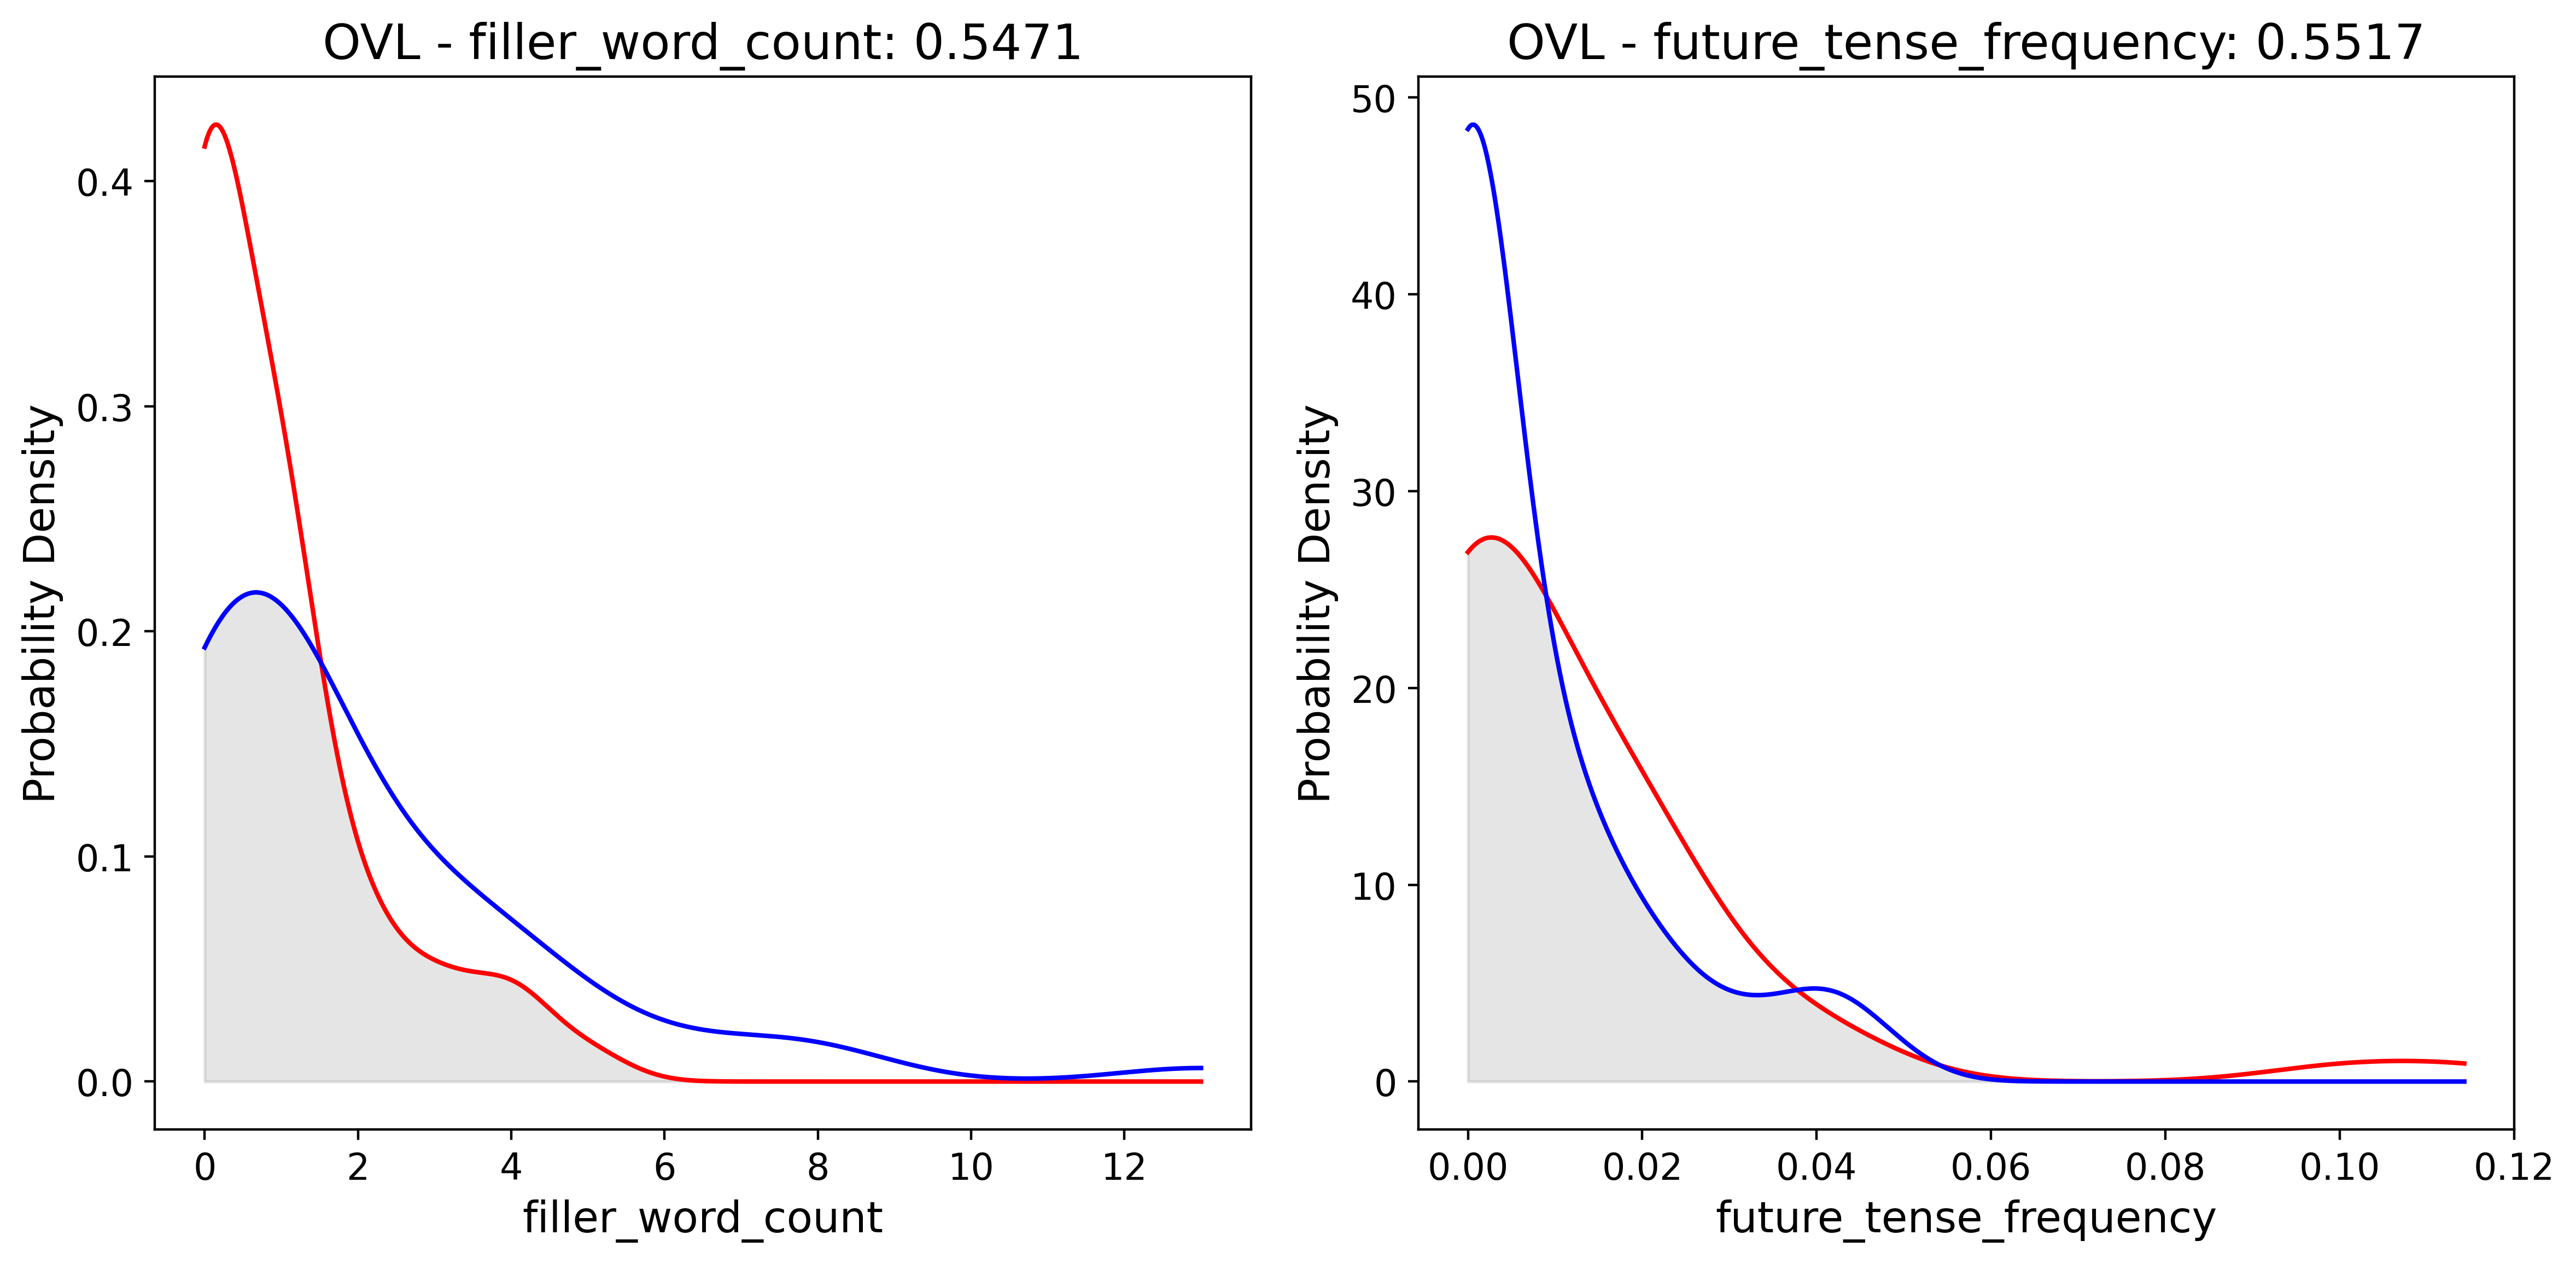

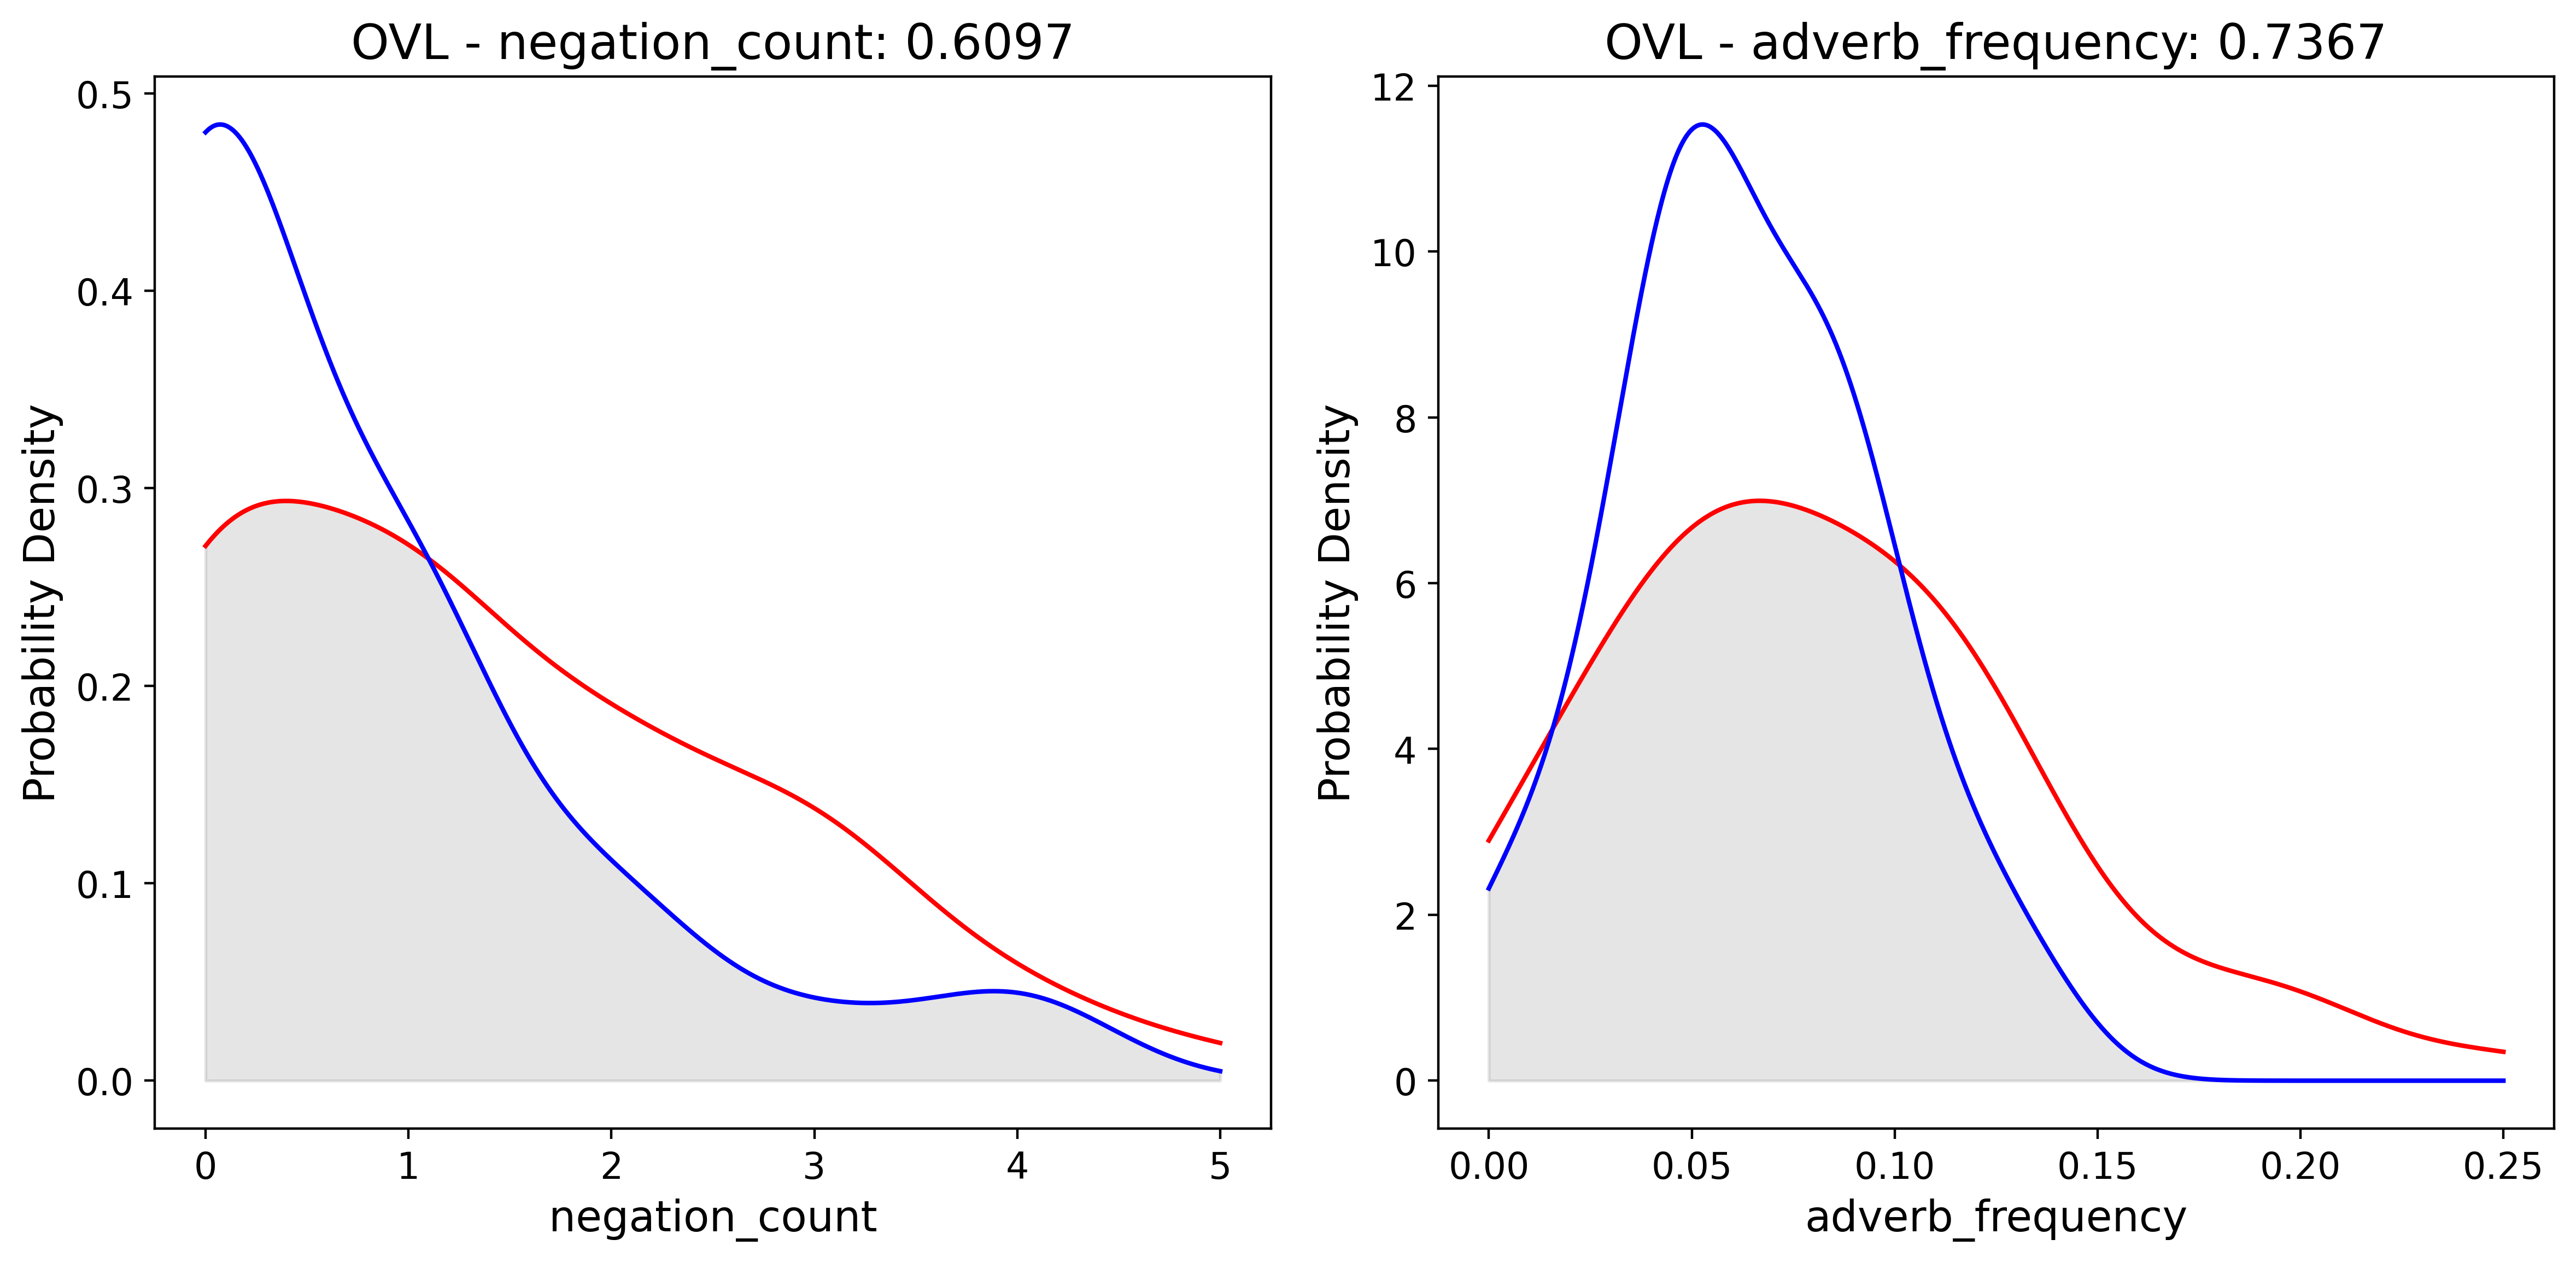

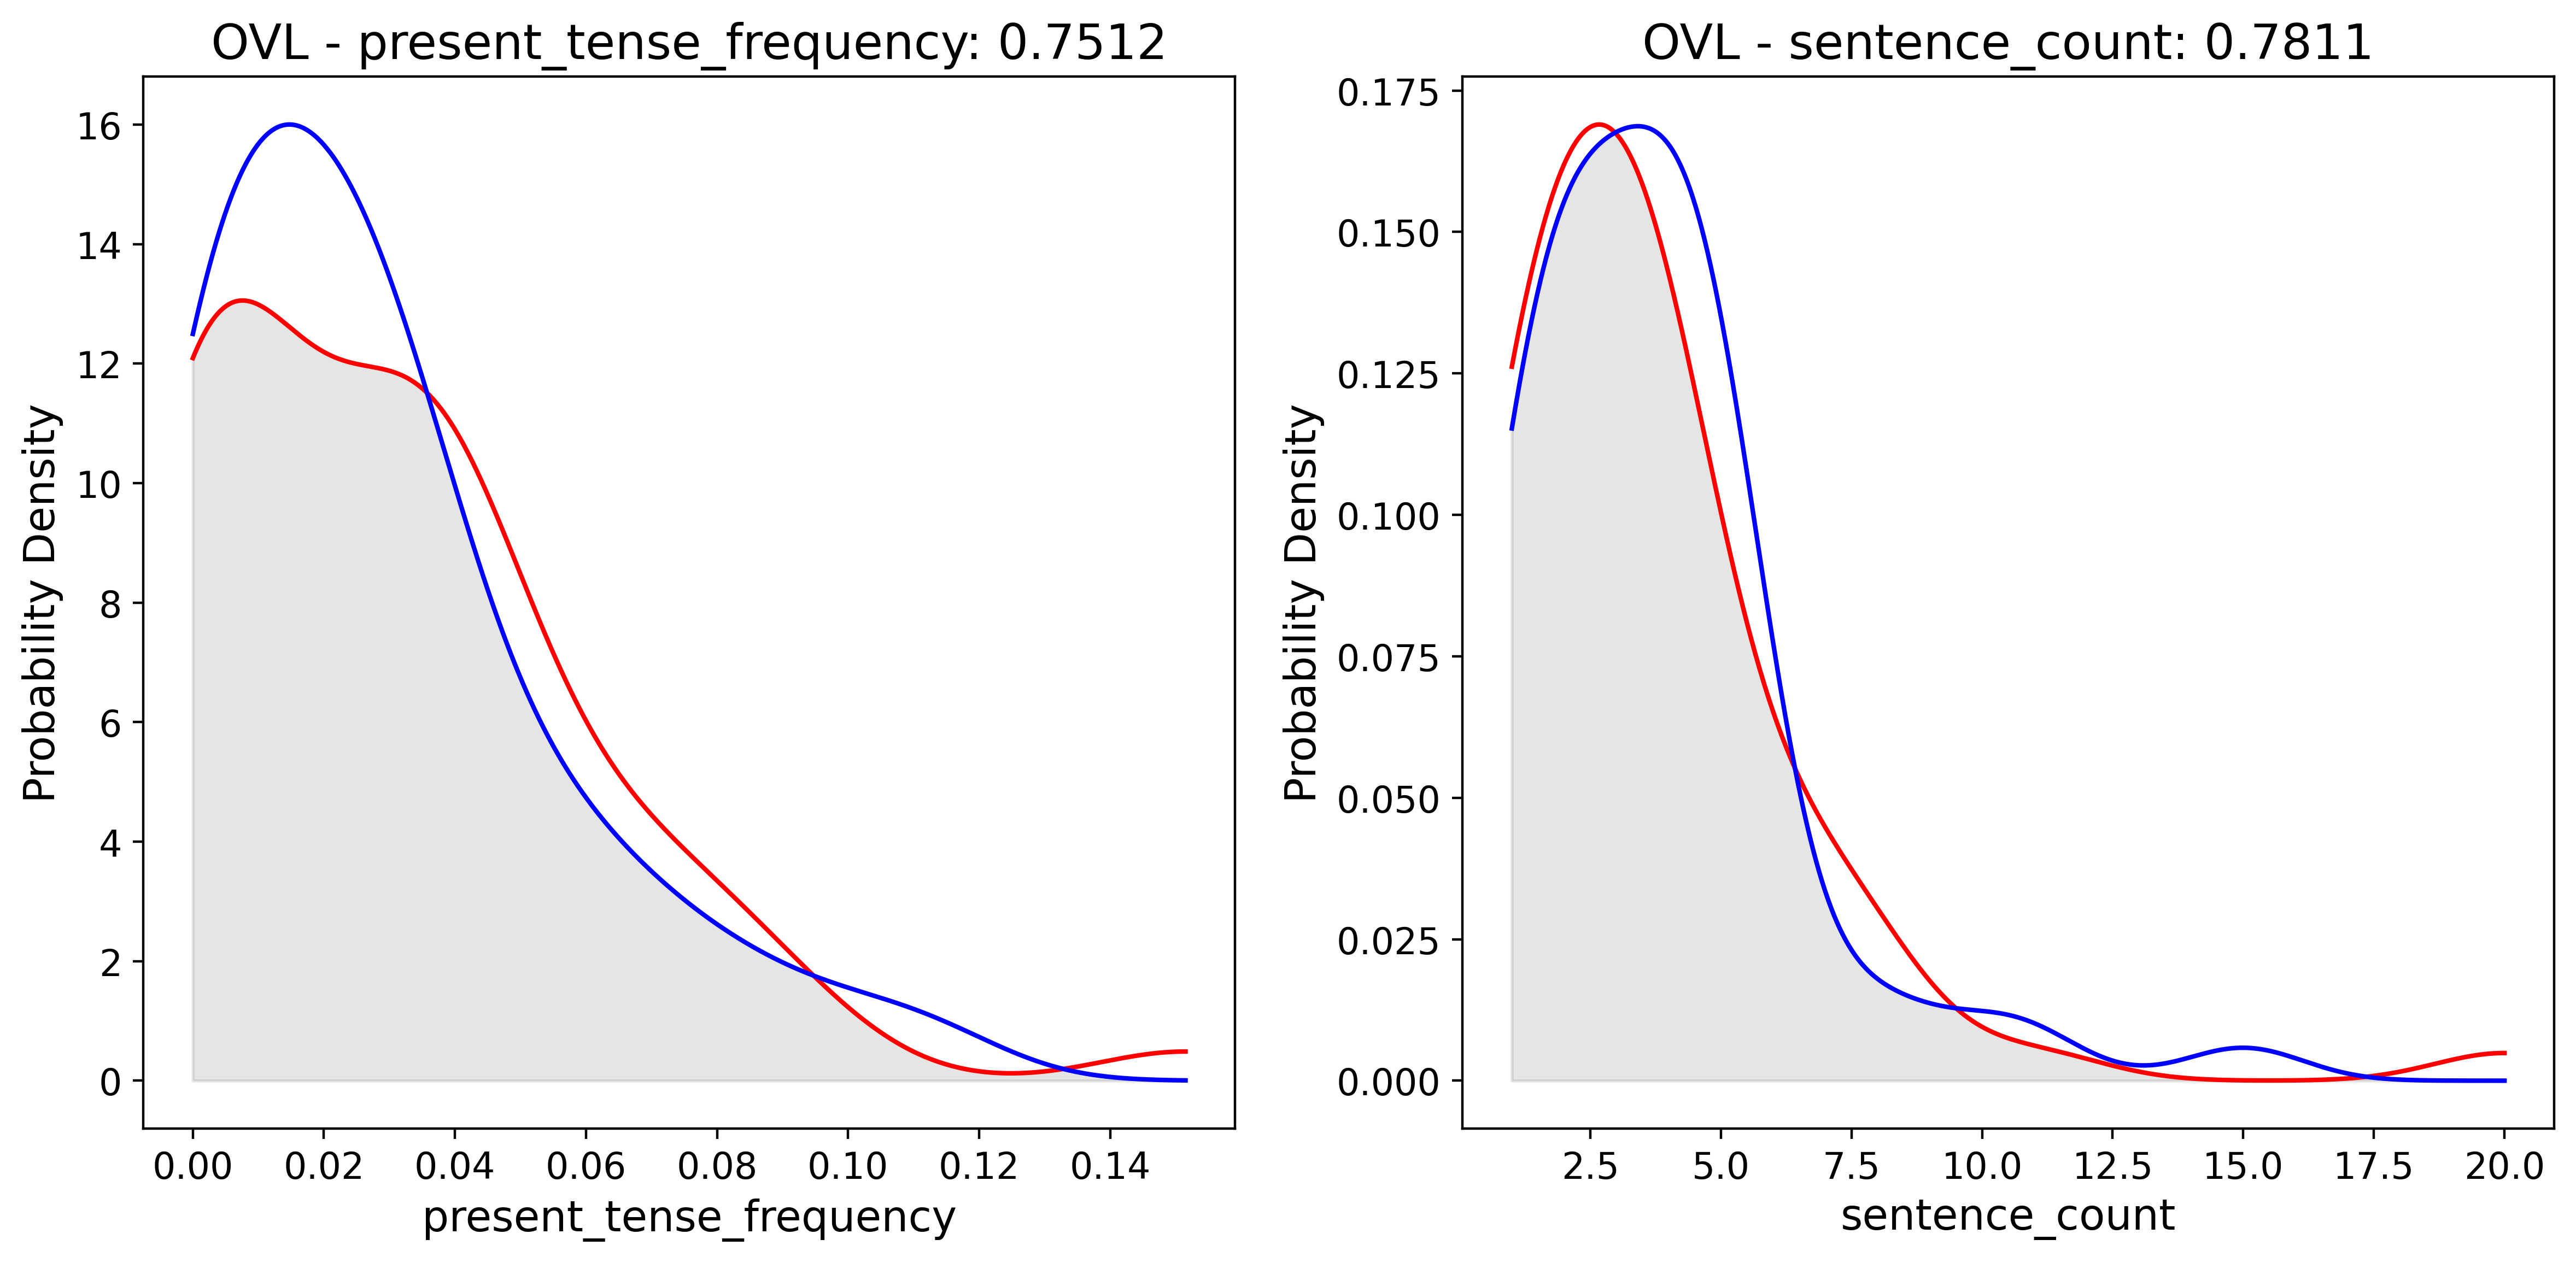

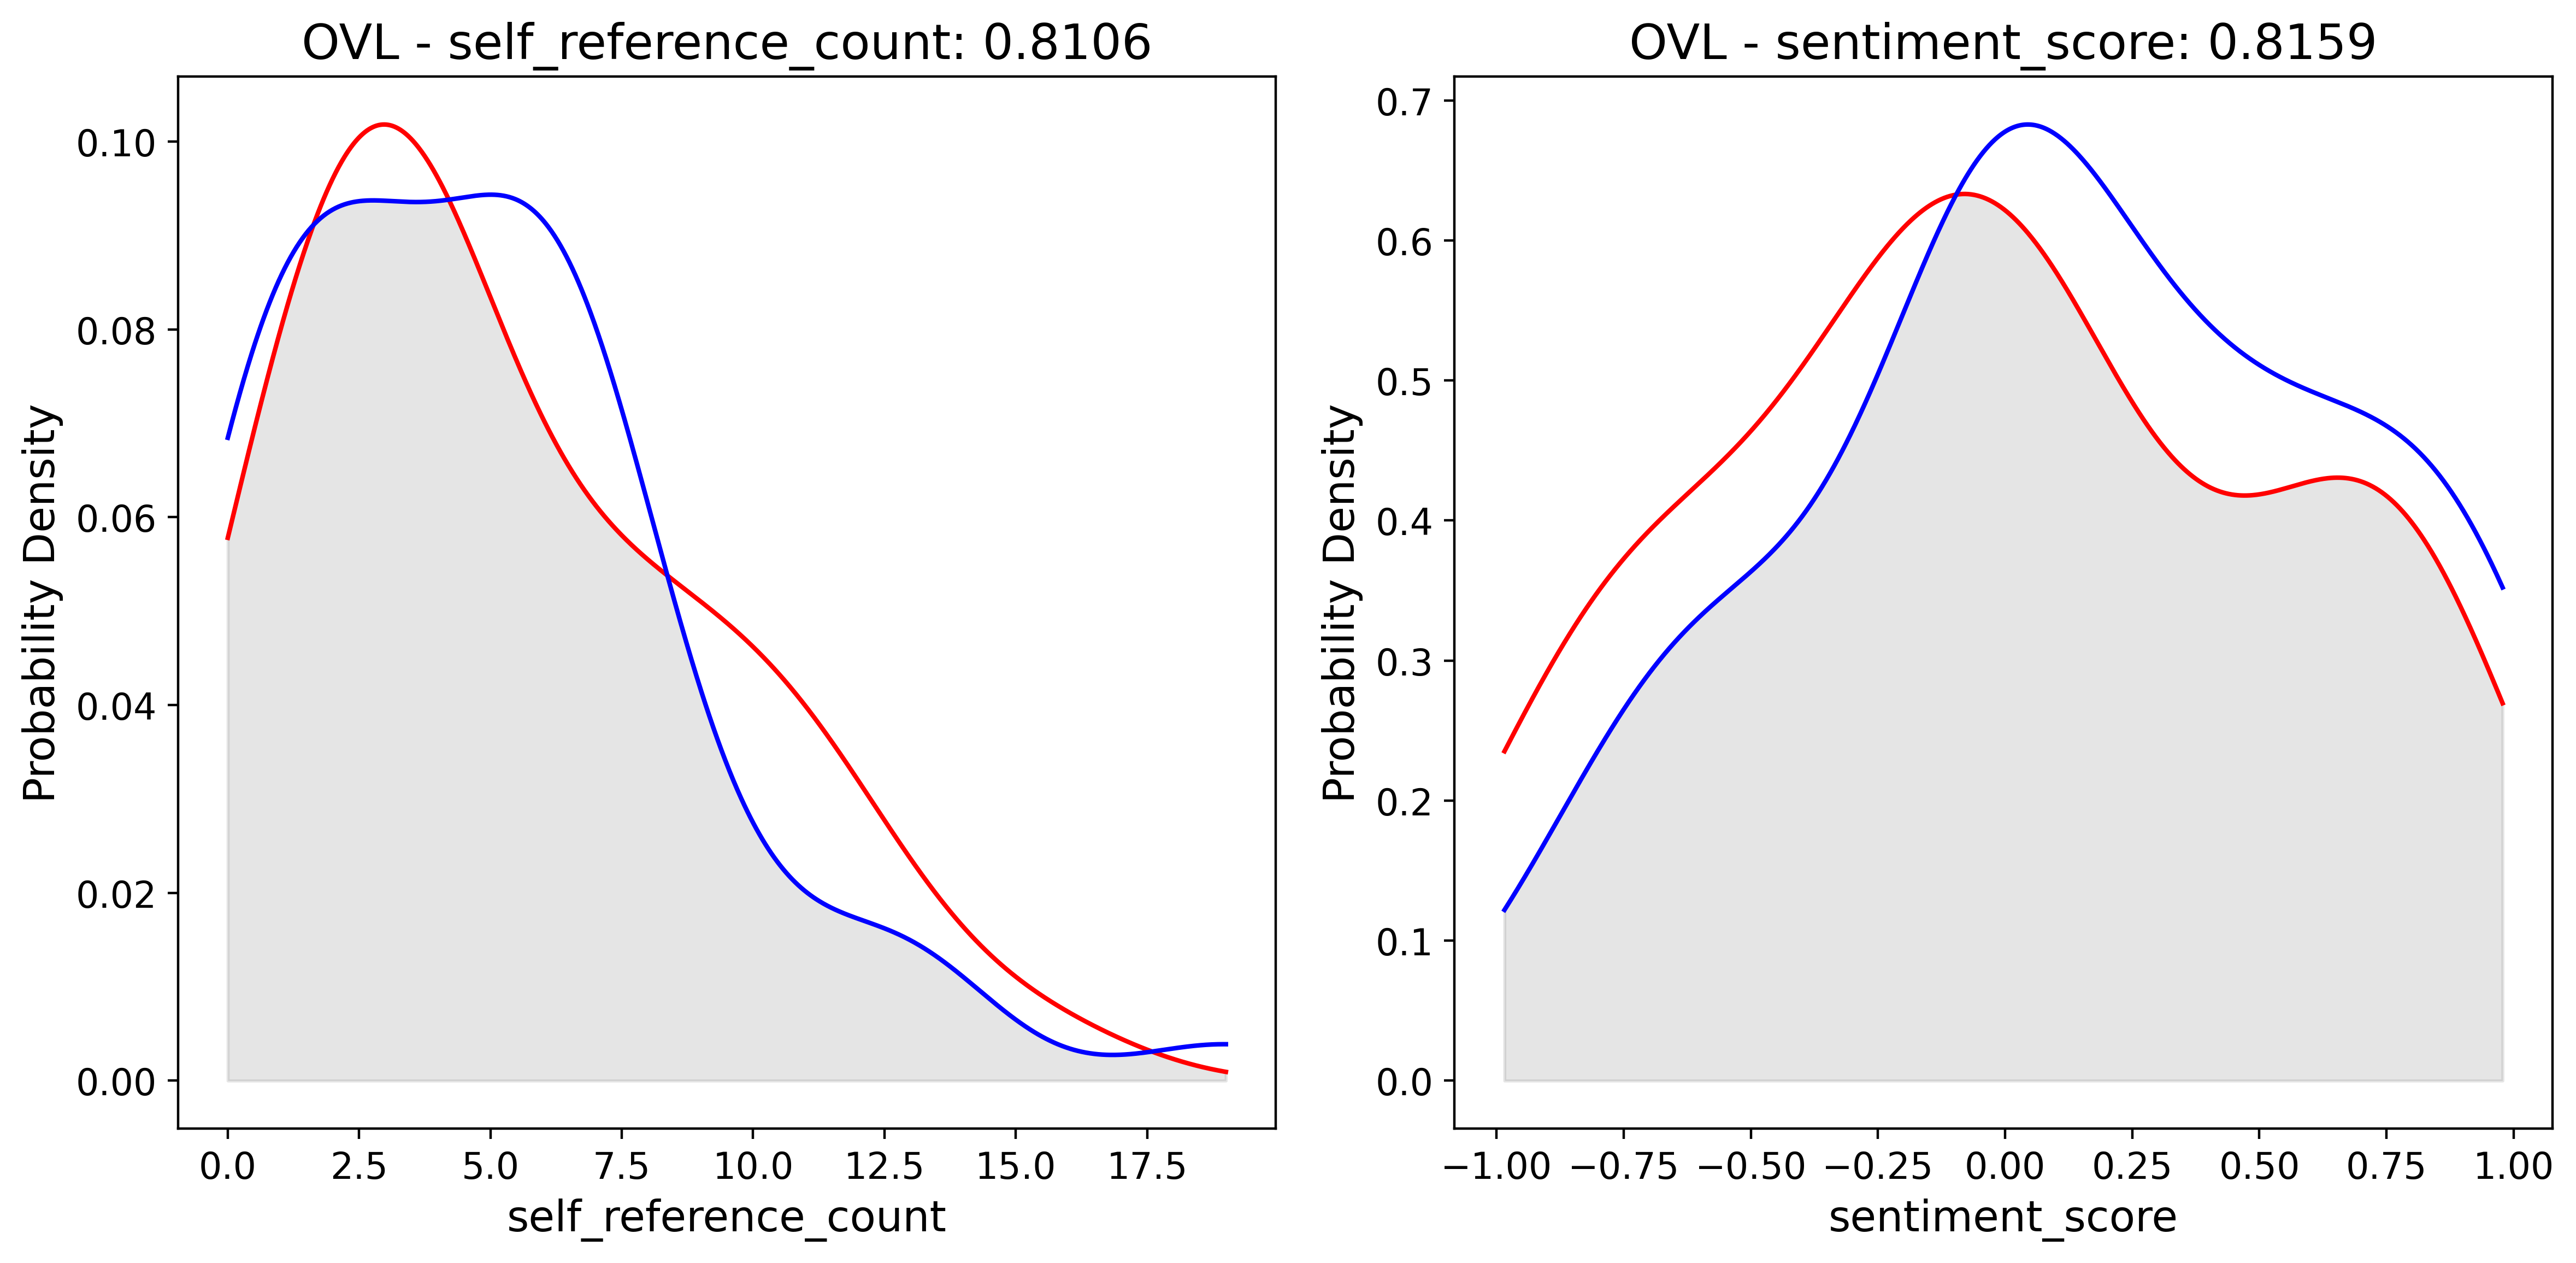

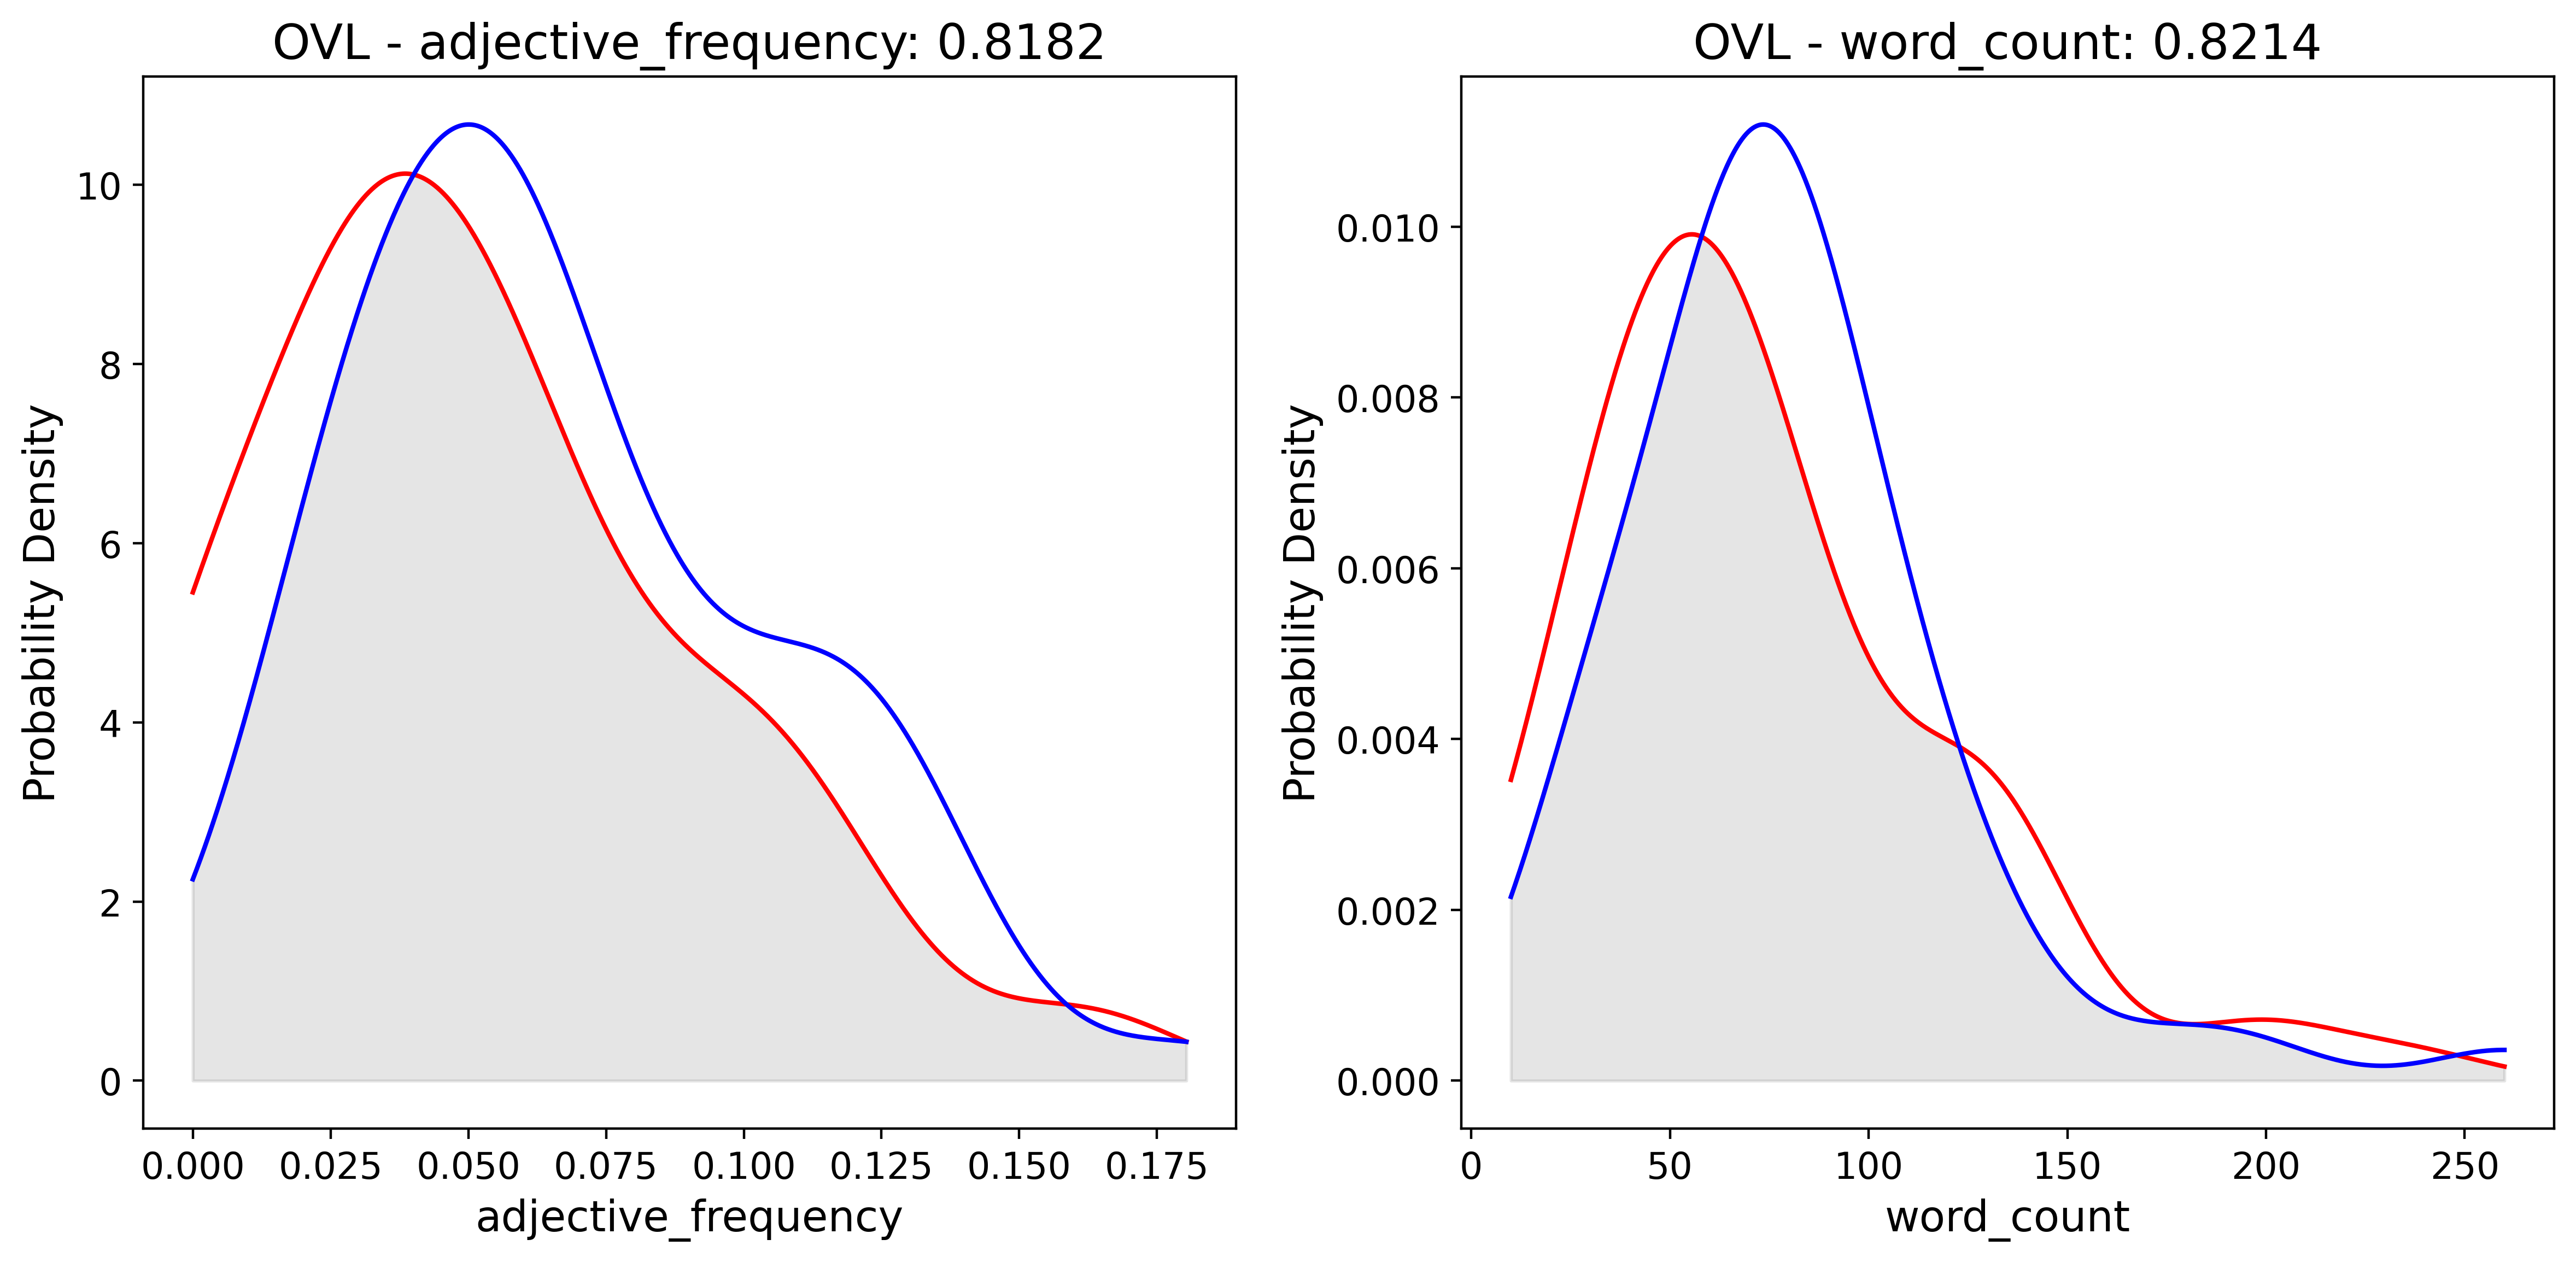

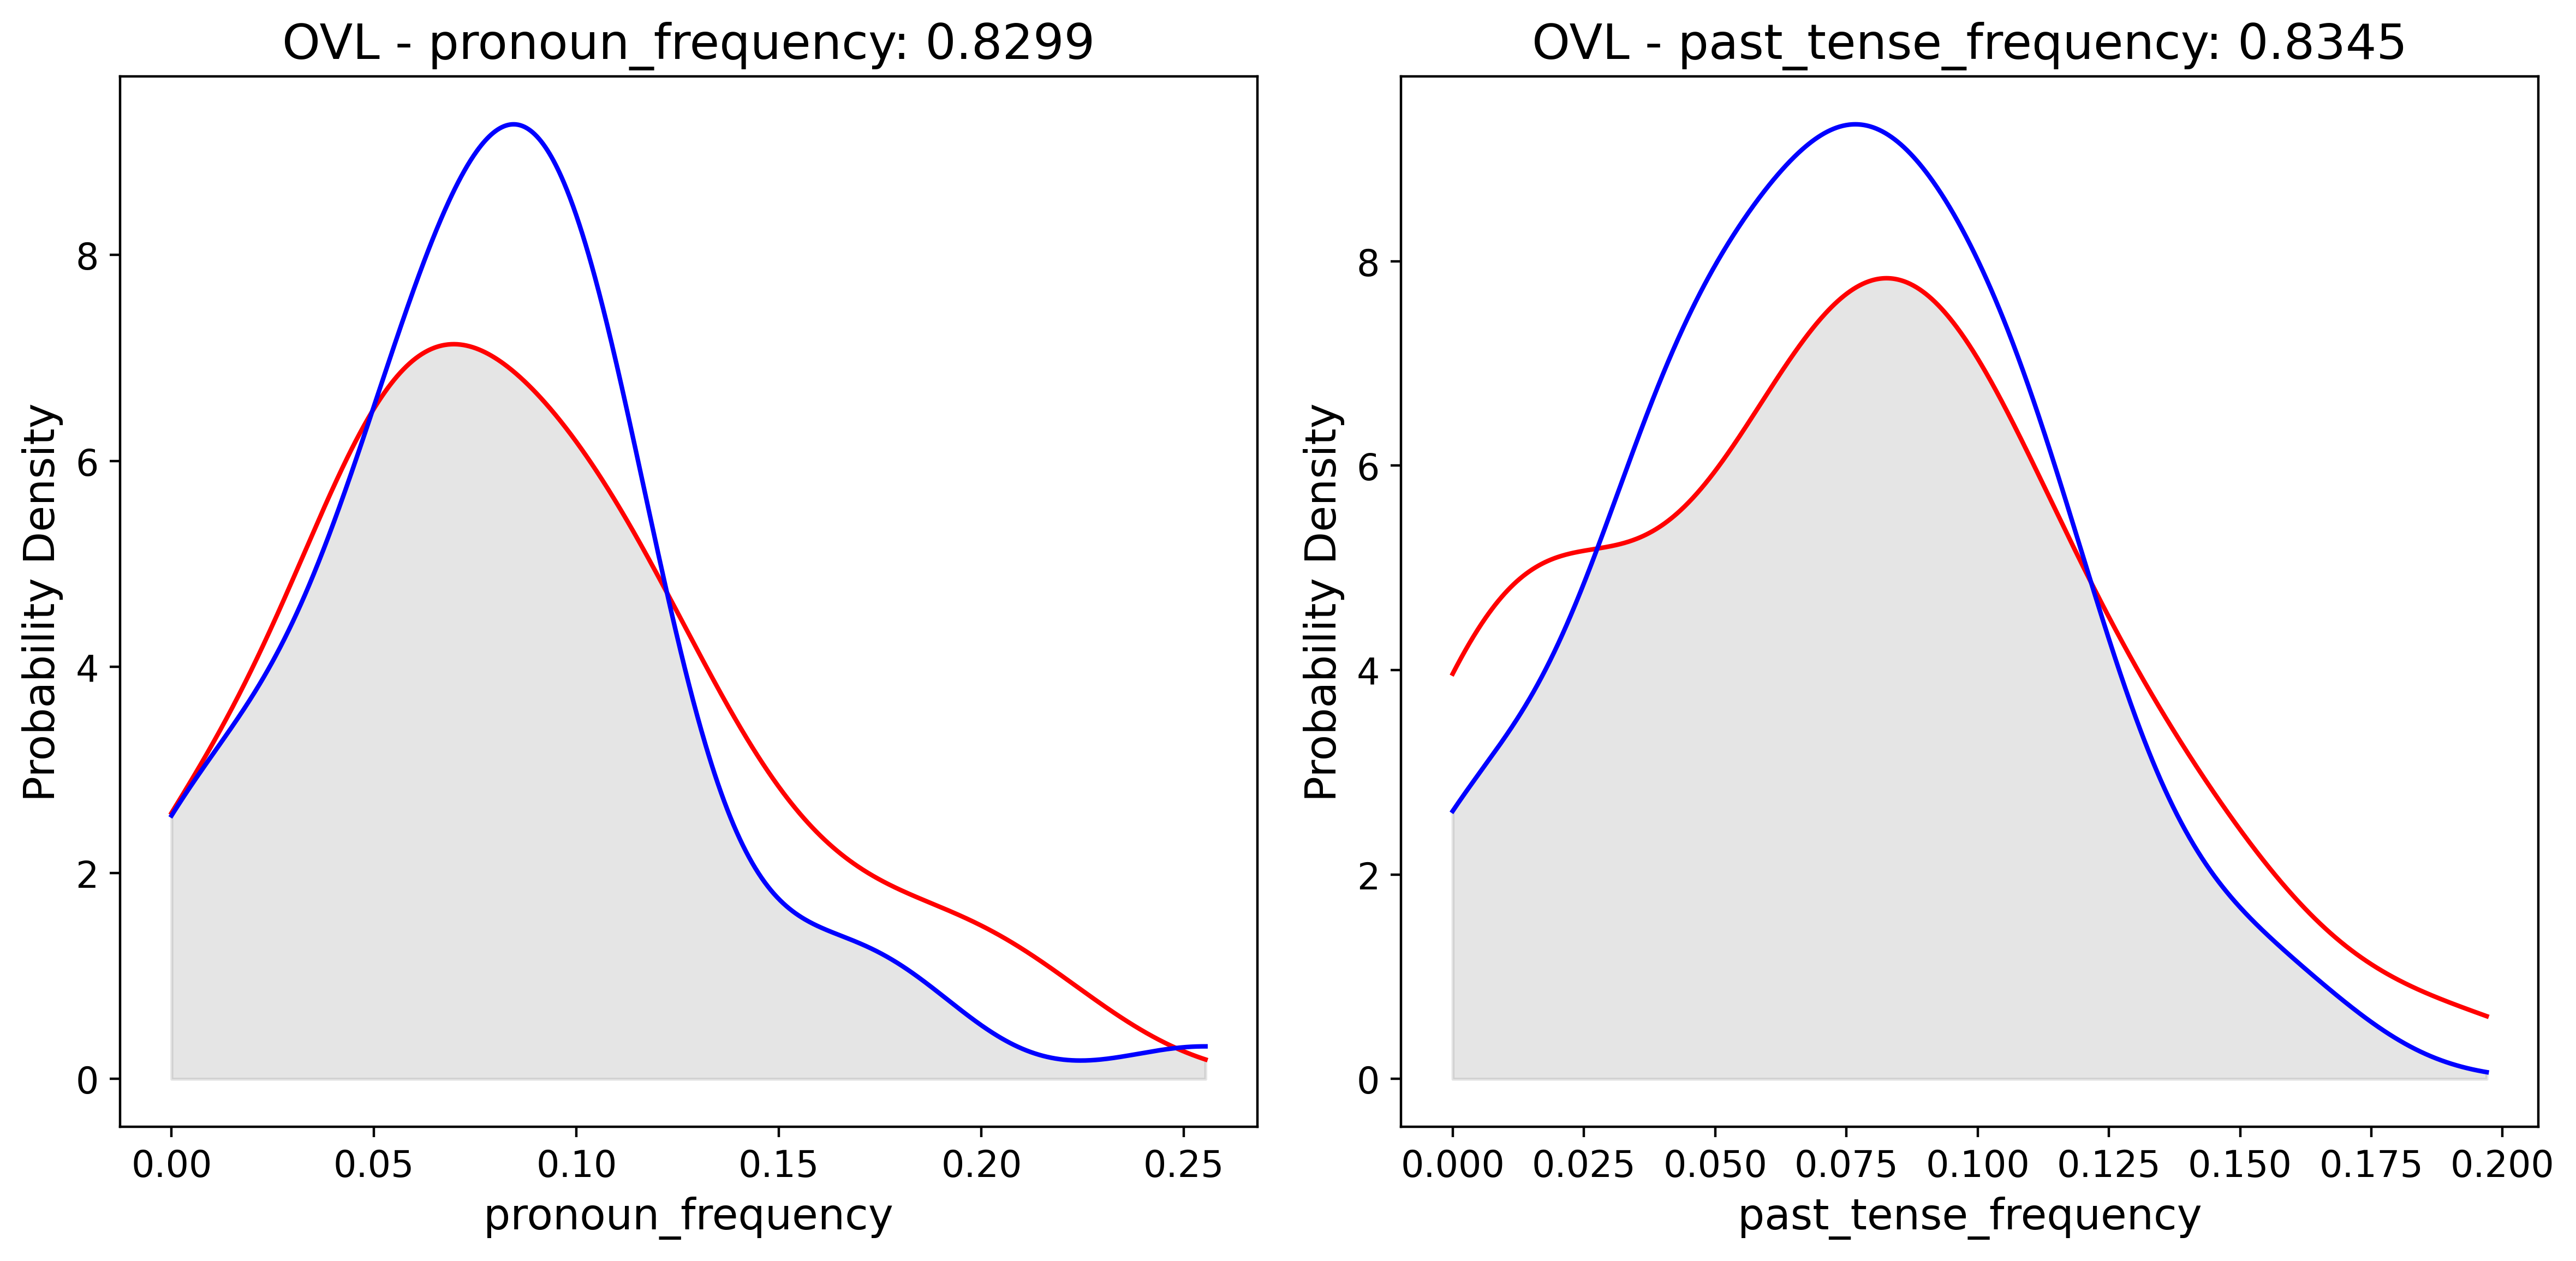

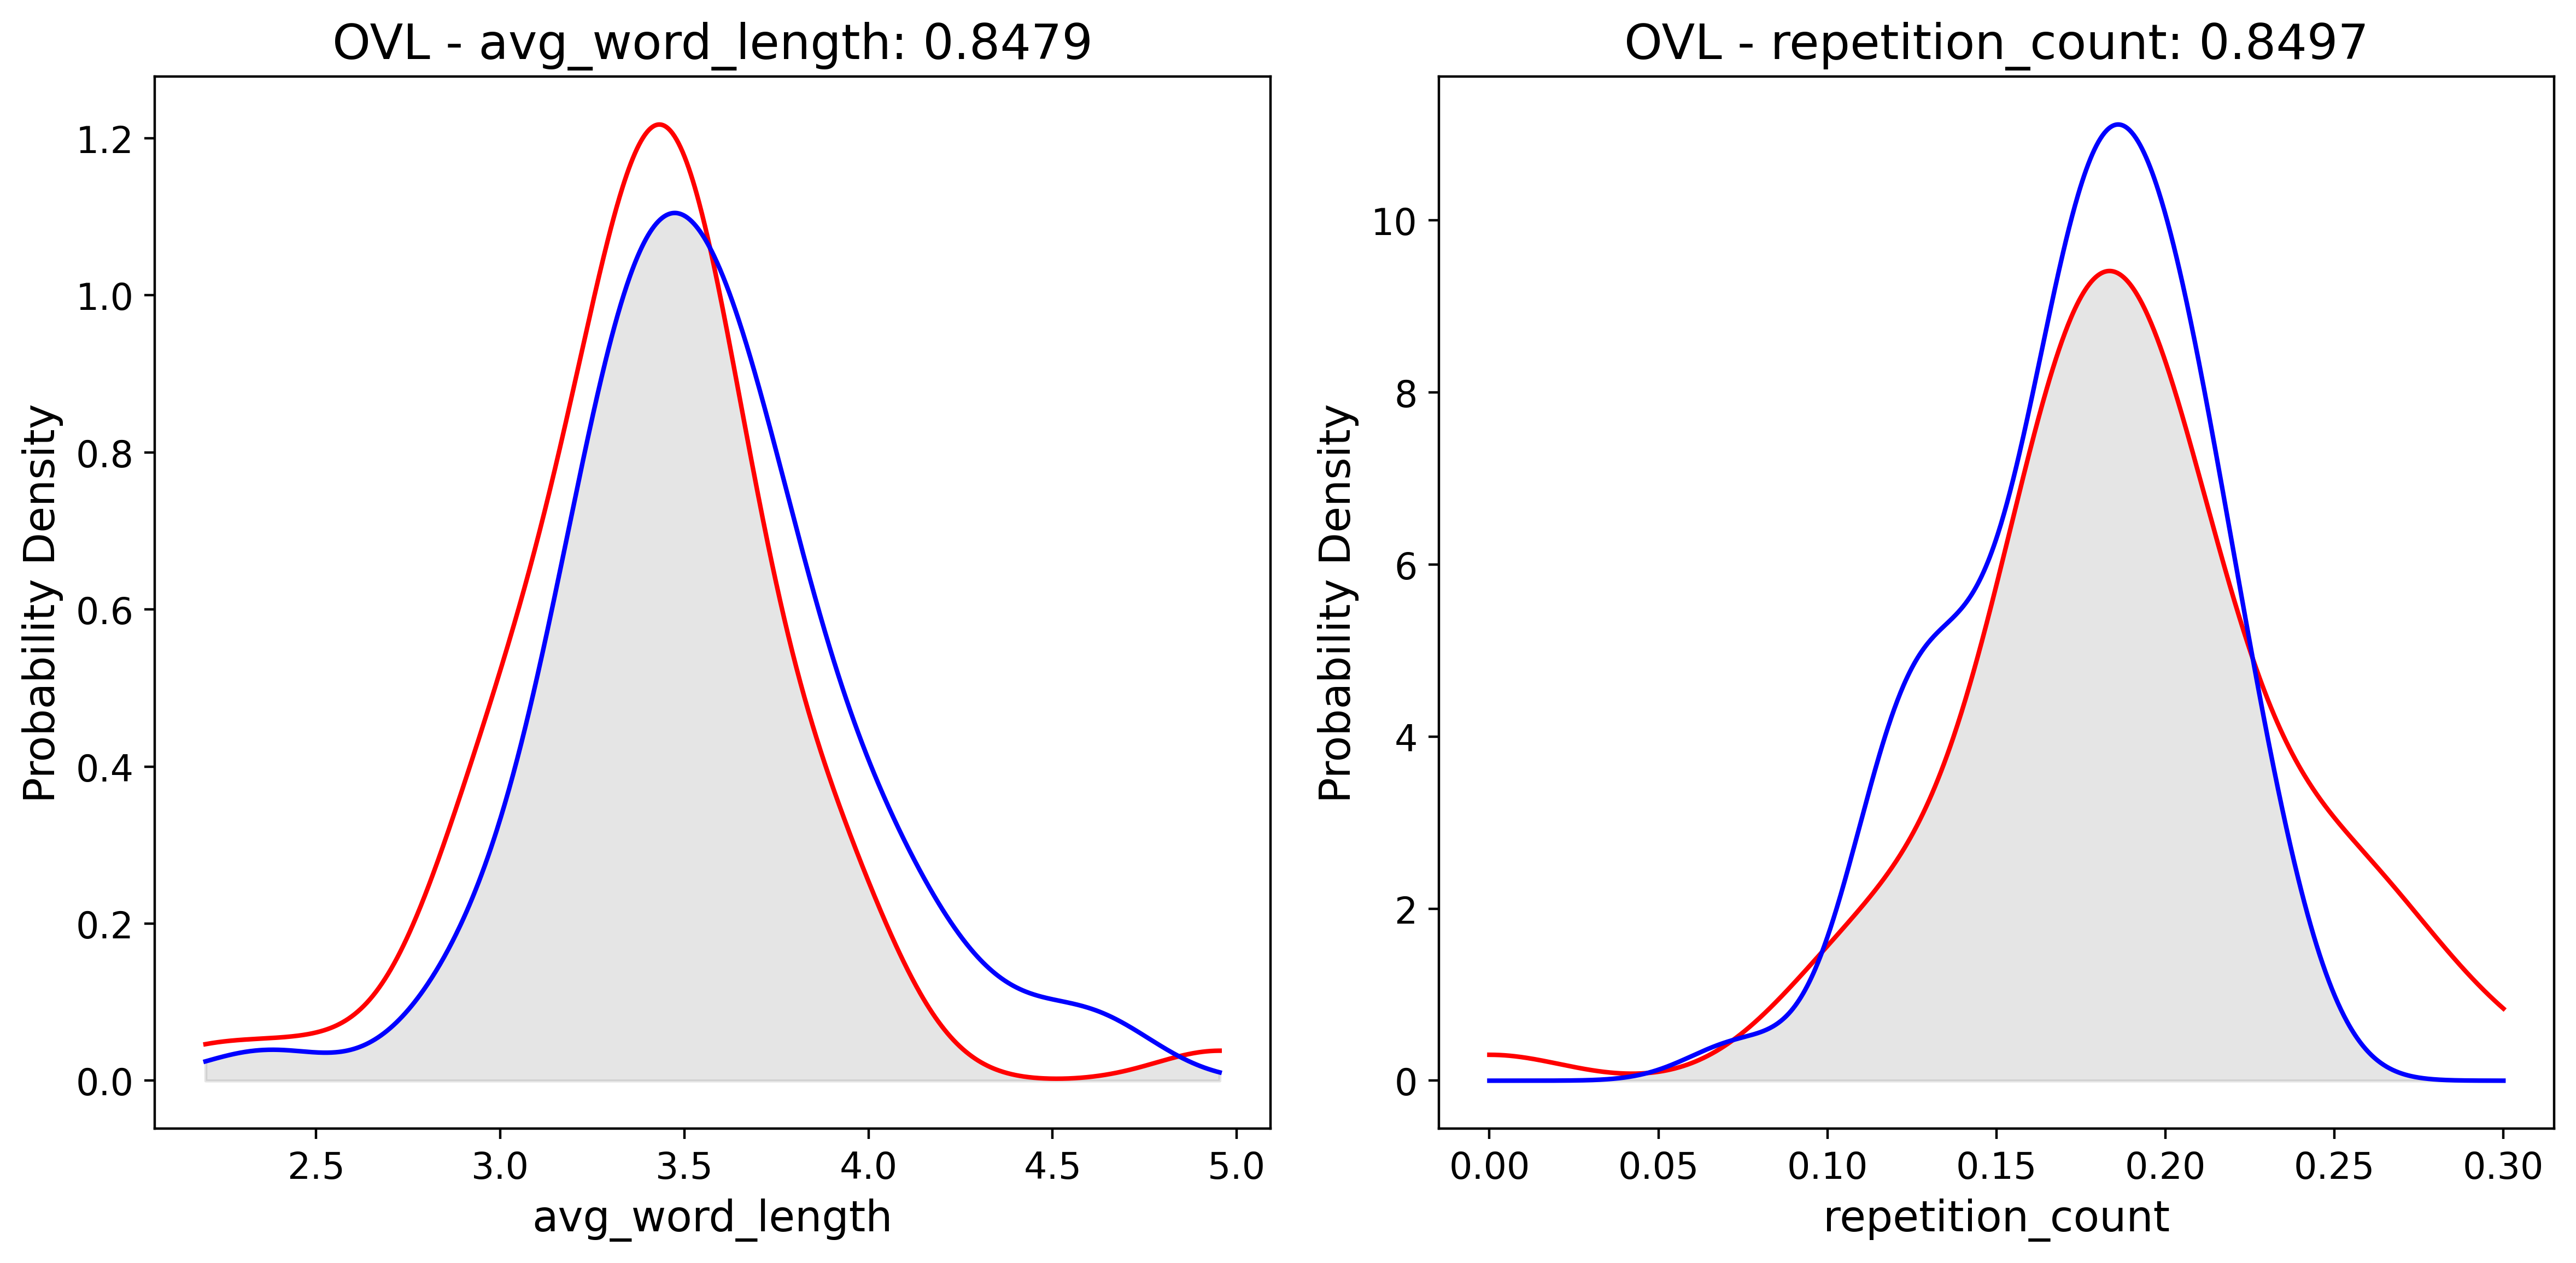

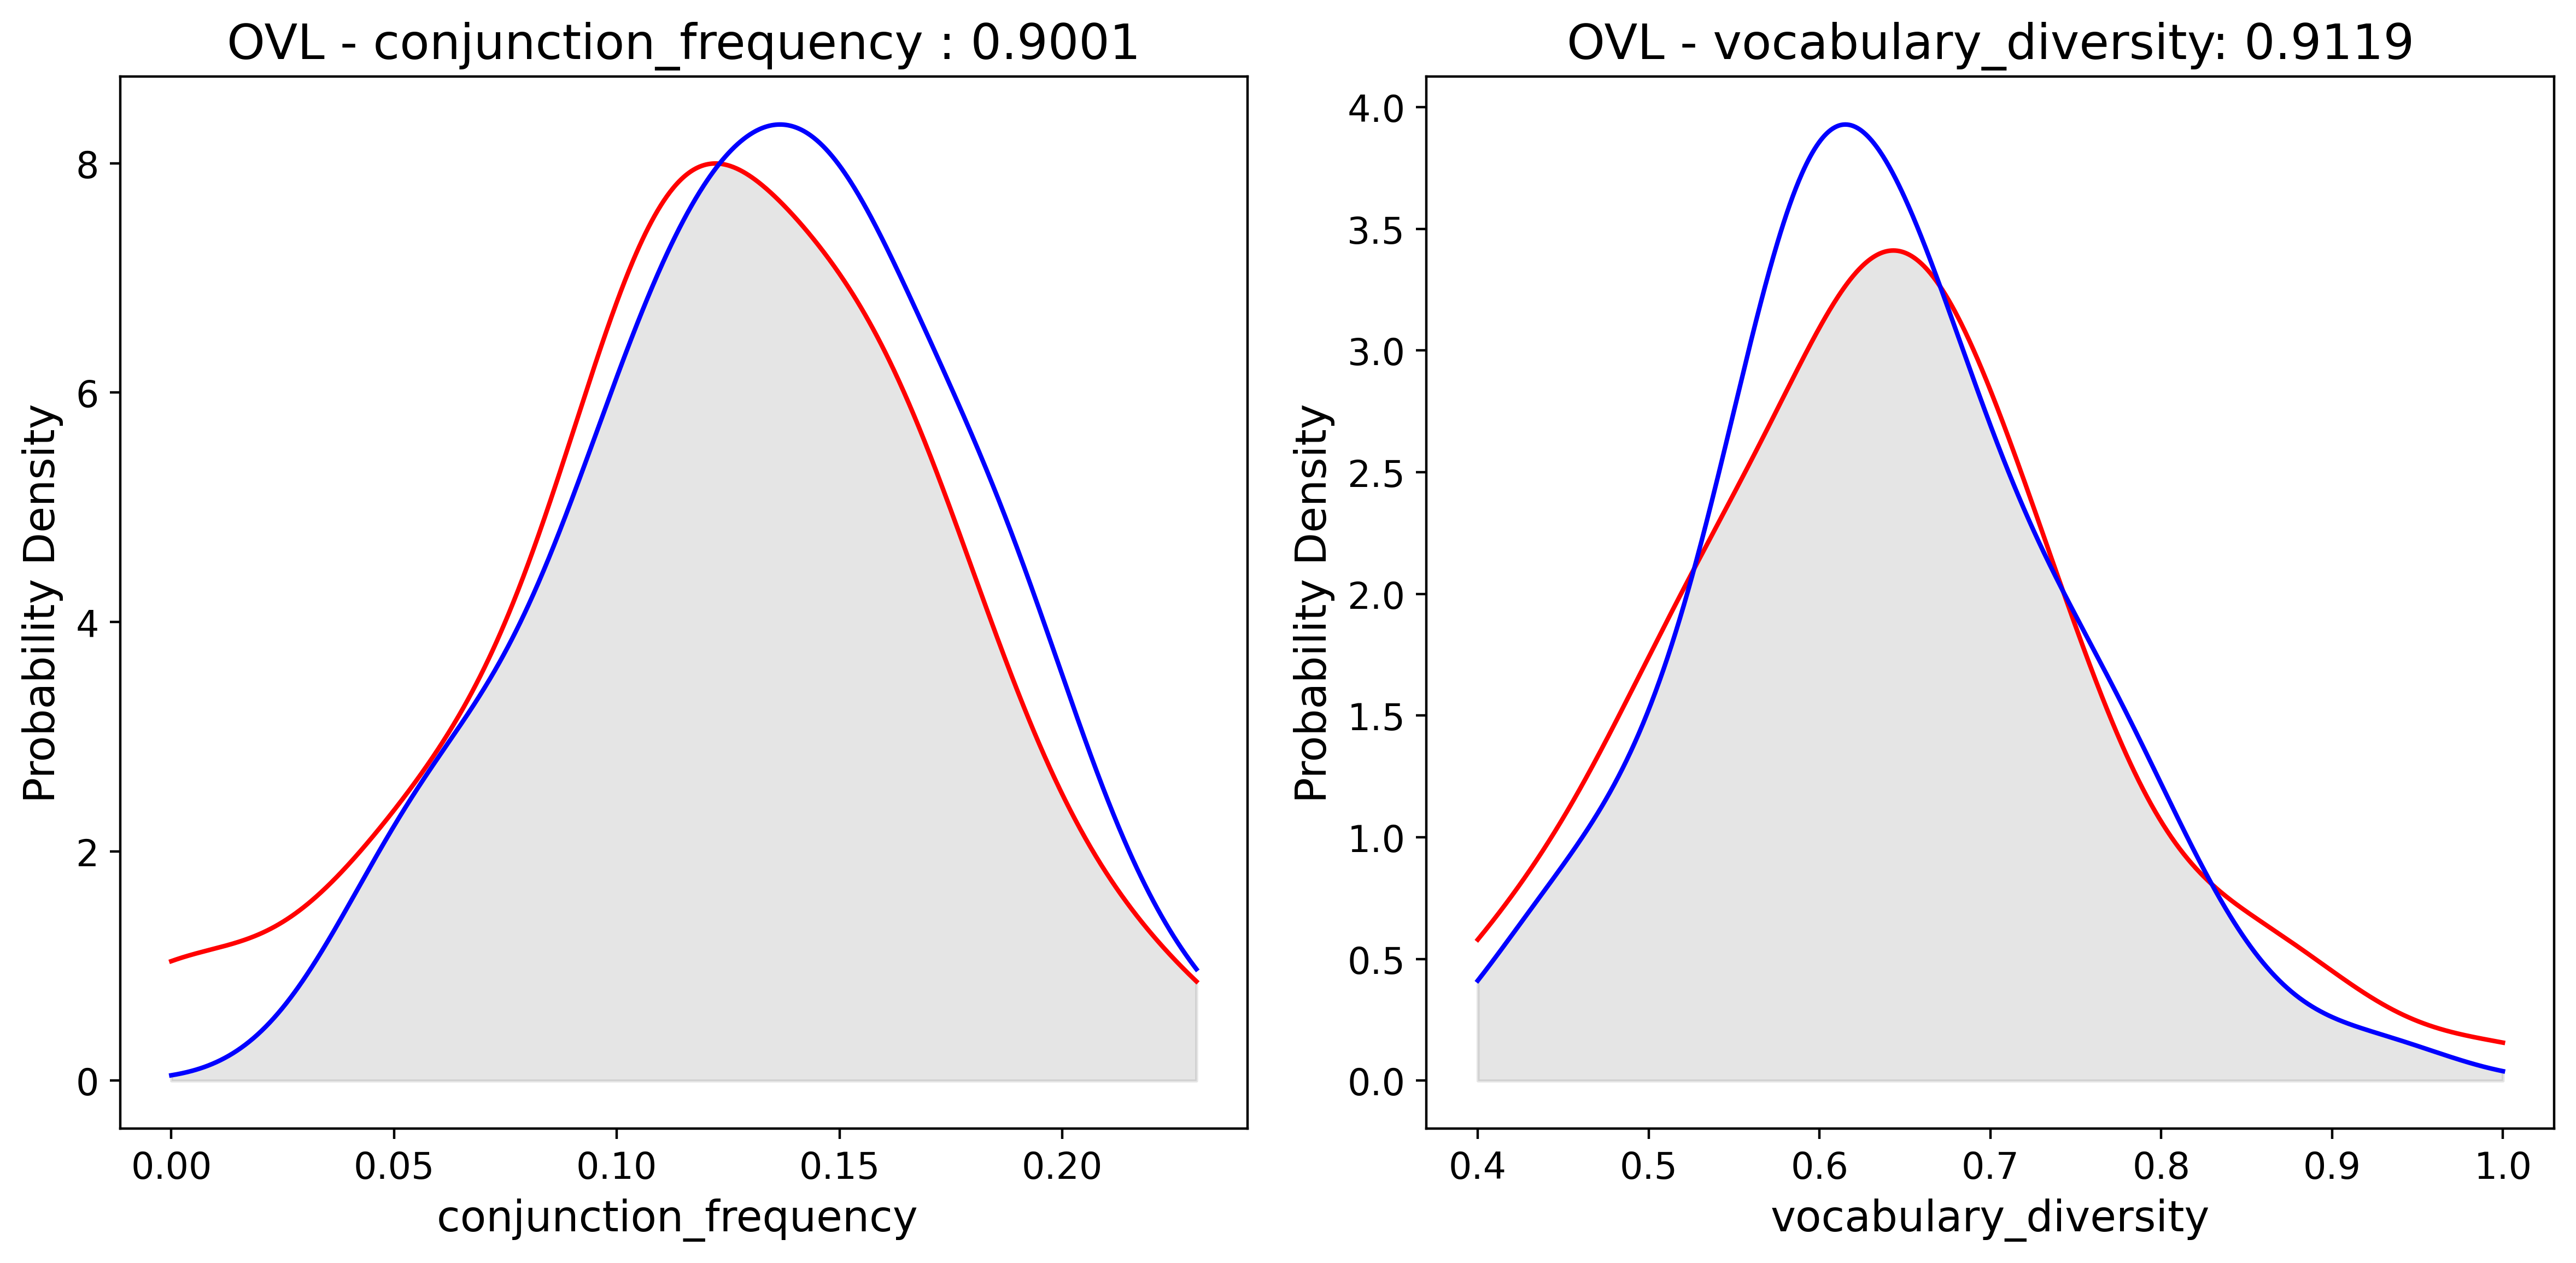

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import pandas as pd
from pathlib import Path

df_features = pd.DataFrame(extracted_features, columns=column_name)

# Separate the data into "lie" and "truth" sets based on the 'label' column
lie_data = df_features[df_features['label'] == 'Lie']
truth_data = df_features[df_features['label'] == 'Truth']

# Define a function to calculate the PDF using Gaussian Kernel Density Estimation (KDE)
def calculate_pdf(data):
    return gaussian_kde(data)

# List to store the results
ovl_results = []

# First, calculate the OVL for each feature and store it
for feature in column_name[1:-1]:  # Exclude 'Speech' and 'label' columns
    lie_pdf = calculate_pdf(lie_data[feature])
    truth_pdf = calculate_pdf(truth_data[feature])

    def ovl(pdf1, pdf2):
        def overlap_integral(x):
            return min(pdf1(x), pdf2(x))

        integral, _ = quad(overlap_integral, df_features[feature].min(), df_features[feature].max())
        return integral

    overlap_coefficient = ovl(lie_pdf, truth_pdf)

    # Store the results in the list
    ovl_results.append({'Feature': feature, 'OVL Score': overlap_coefficient})

# Create a DataFrame from the results
ovl_df = pd.DataFrame(ovl_results)

# Sort the DataFrame by OVL Score (from lowest to highest)
ovl_df = ovl_df.sort_values(by='OVL Score')

# Plot two PDFs per row
num_plots = 2  # Two plots per row
total_features = len(ovl_df)
rows = (total_features + num_plots - 1) // num_plots  # Calculate the number of rows needed

# Set font sizes for better readability
plt.rcParams.update({
    'font.size': 14,        # Base font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 14,   # Axis label font size
    'xtick.labelsize': 12,  # X tick label font size
    'ytick.labelsize': 12,  # Y tick label font size
})

# Loop through each row and save them as separate images
for row_num in range(rows):
    # Create a figure for each row
    fig, axes = plt.subplots(1, num_plots, figsize=(12, 6), dpi=400)
    axes = axes.flatten()

    for idx in range(num_plots):
        feature_idx = row_num * num_plots + idx

        if feature_idx >= total_features:
            # If there are no more features to plot, remove the extra subplot
            fig.delaxes(axes[idx])
            continue

        # Get the feature for this plot
        feature = ovl_df.iloc[feature_idx]['Feature']
        lie_pdf = calculate_pdf(lie_data[feature])
        truth_pdf = calculate_pdf(truth_data[feature])

        # Plot the PDFs
        x = np.linspace(df_features[feature].min(), df_features[feature].max(), 1000)
        axes[idx].plot(x, lie_pdf(x), color='red', label='Lie PDF' if feature_idx == 0 else "")  # Only label the first plot
        axes[idx].plot(x, truth_pdf(x), color='blue', label='Truth PDF' if feature_idx == 0 else "")  # Only label the first plot
        axes[idx].fill_between(x, 0, np.minimum(lie_pdf(x), truth_pdf(x)), color='gray', alpha=0.2, label='Overlap' if feature_idx == 0 else "")  # Only label the first plot
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Probability Density')
        axes[idx].set_title(f'OVL - {feature}: {ovl_df.iloc[feature_idx]["OVL Score"]:.4f}')

    plt.tight_layout()

    # Save each row as a separate image
    save_path = f"/content/drive/MyDrive/Tien-297/Real-life_Deception_Detection_2016/OVL_plots_row_{row_num + 1}.png"
    plt.savefig(save_path, dpi=400, bbox_inches='tight')

    plt.show()  # Display the plot for each row

    # Close the figure to free memory
    plt.close(fig)


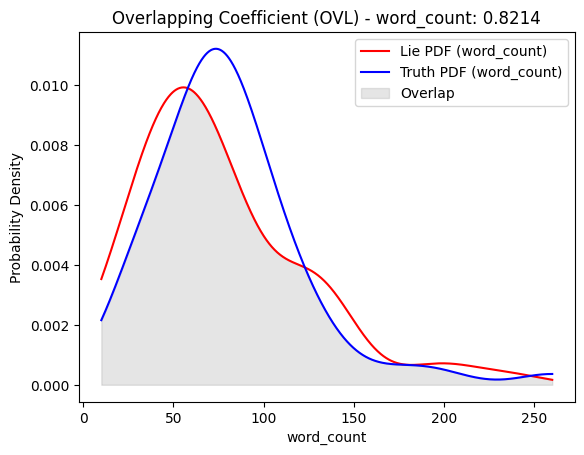

Overlapping Coefficient (OVL) - word_count: 0.8214


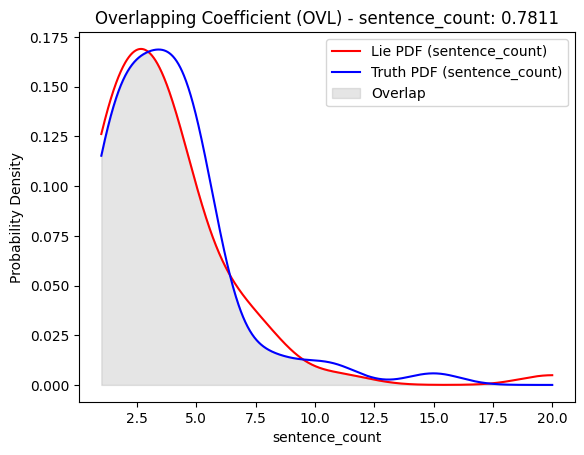

Overlapping Coefficient (OVL) - sentence_count: 0.7811


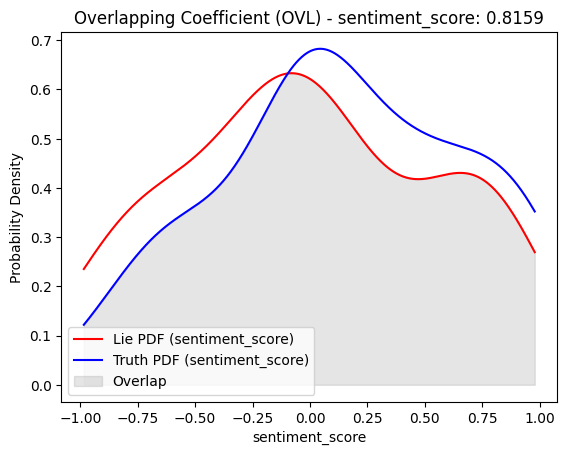

Overlapping Coefficient (OVL) - sentiment_score: 0.8159


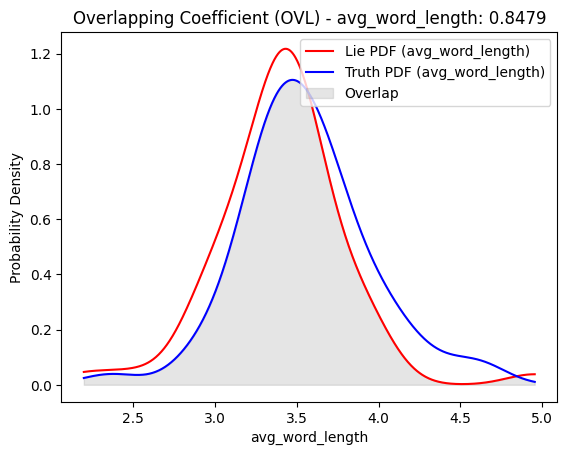

Overlapping Coefficient (OVL) - avg_word_length: 0.8479


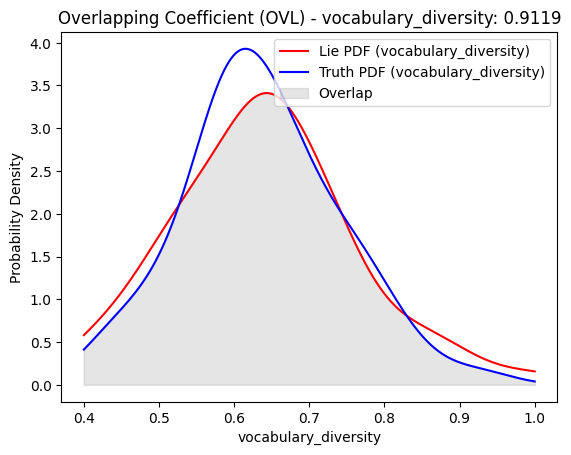

Overlapping Coefficient (OVL) - vocabulary_diversity: 0.9119


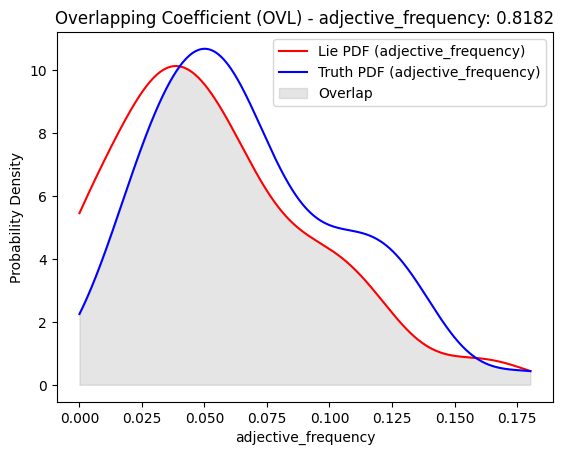

Overlapping Coefficient (OVL) - adjective_frequency: 0.8182


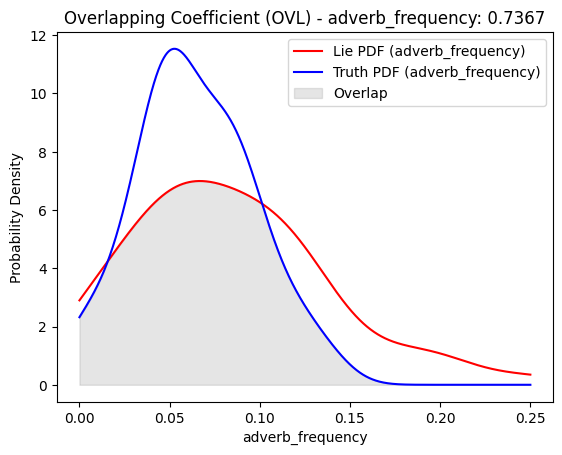

Overlapping Coefficient (OVL) - adverb_frequency: 0.7367


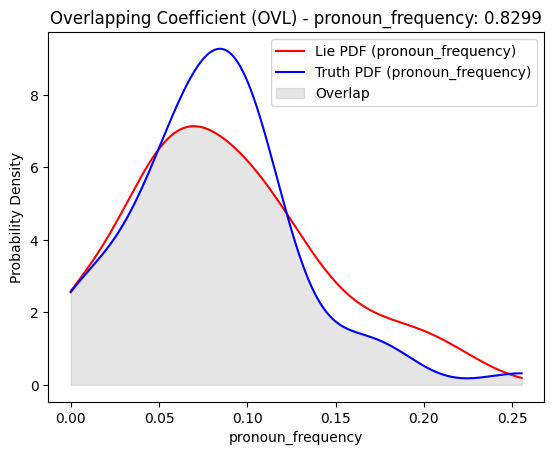

Overlapping Coefficient (OVL) - pronoun_frequency: 0.8299


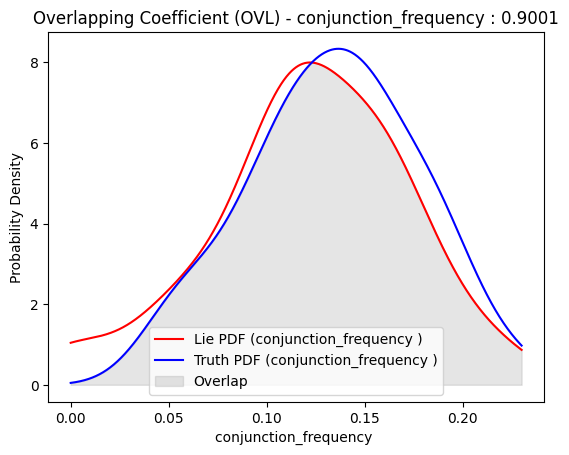

Overlapping Coefficient (OVL) - conjunction_frequency : 0.9001


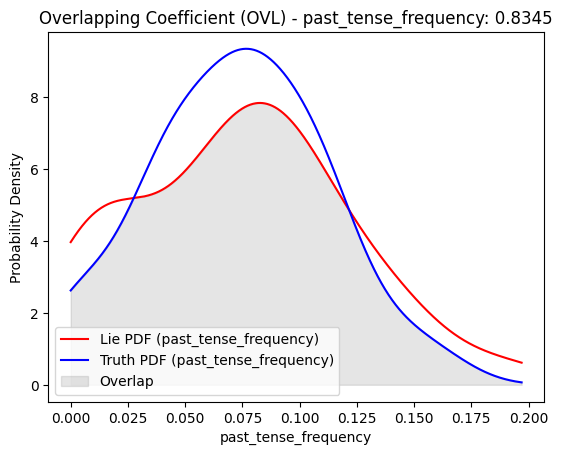

Overlapping Coefficient (OVL) - past_tense_frequency: 0.8345


<ipython-input-5-3f82a6046079>:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(overlap_integral, df_features[feature].min(), df_features[feature].max())


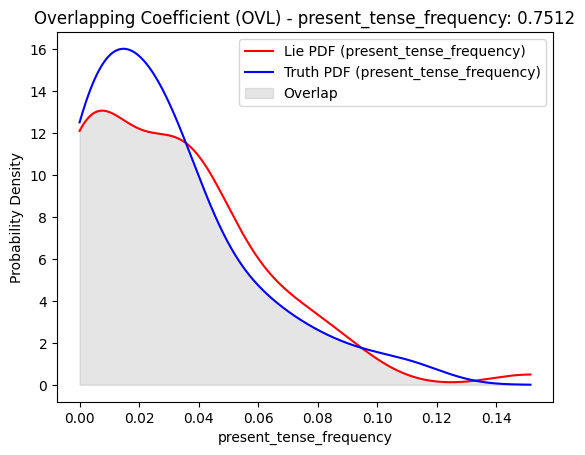

Overlapping Coefficient (OVL) - present_tense_frequency: 0.7512


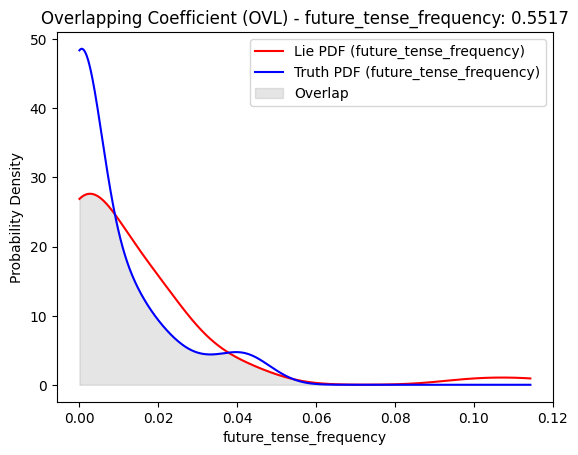

Overlapping Coefficient (OVL) - future_tense_frequency: 0.5517


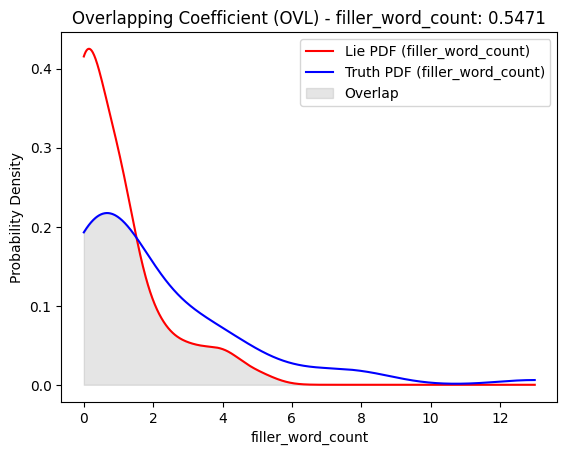

Overlapping Coefficient (OVL) - filler_word_count: 0.5471


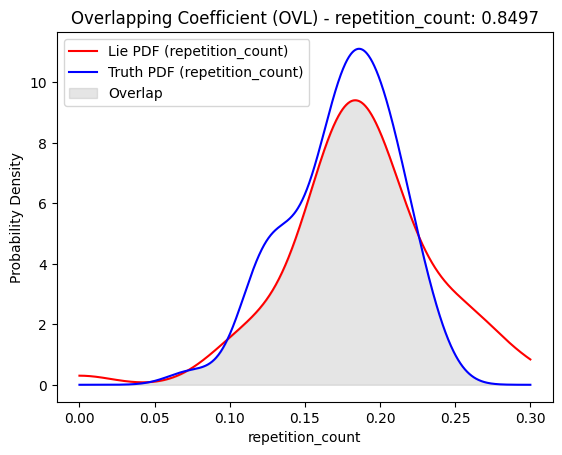

Overlapping Coefficient (OVL) - repetition_count: 0.8497


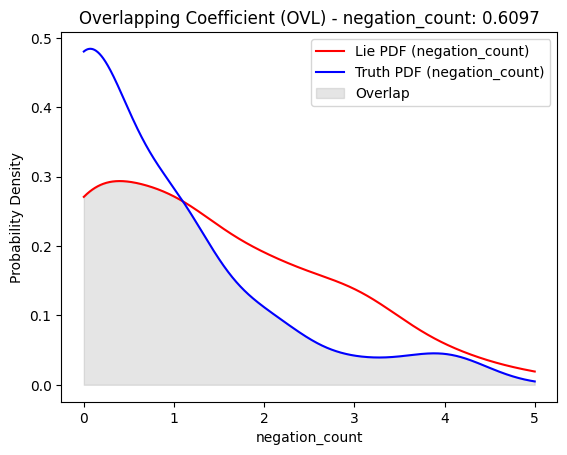

Overlapping Coefficient (OVL) - negation_count: 0.6097


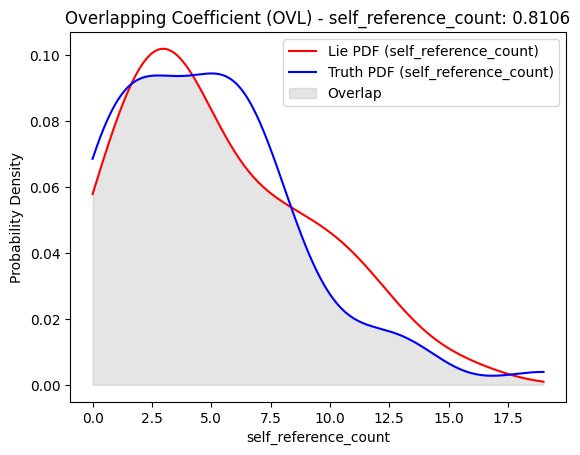

Overlapping Coefficient (OVL) - self_reference_count: 0.8106


Feature  OVL Score
12        filler_word_count   0.547099
11   future_tense_frequency   0.551706
14           negation_count   0.609744
6          adverb_frequency   0.736650
10  present_tense_frequency   0.751172
1            sentence_count   0.781123
15     self_reference_count   0.810572
2           sentiment_score   0.815940
5       adjective_frequency   0.818153
0                word_count   0.821388
7         pronoun_frequency   0.829933
9      past_tense_frequency   0.834495
3           avg_word_length   0.847896
13         repetition_count   0.849696
8    conjunction_frequency    0.900058
4      vocabulary_diversity   0.911909

In [5]:
df_features = pd.DataFrame(extracted_features, columns=column_name)

# Separate the data into "lie" and "truth" sets based on the 'label' column
lie_data = df_features[df_features['label'] == 'Lie']
truth_data = df_features[df_features['label'] == 'Truth']

# Define a function to calculate the PDF using Gaussian Kernel Density Estimation (KDE)
def calculate_pdf(data):
    return gaussian_kde(data)

# List to store the results
ovl_results = []

# Calculate and plot the OVL for each feature
for feature in column_name[1:-1]:  # Exclude 'Speech' and 'label' columns
    lie_pdf = calculate_pdf(lie_data[feature])
    truth_pdf = calculate_pdf(truth_data[feature])

    def ovl(pdf1, pdf2):
        def overlap_integral(x):
            return min(pdf1(x), pdf2(x))

        integral, _ = quad(overlap_integral, df_features[feature].min(), df_features[feature].max())
        return integral

    overlap_coefficient = ovl(lie_pdf, truth_pdf)

    # Store the results in the list
    ovl_results.append({'Feature': feature, 'OVL Score': overlap_coefficient})

    # Plot the PDFs
    x = np.linspace(df_features[feature].min(), df_features[feature].max(), 1000)
    plt.plot(x, lie_pdf(x), label=f'Lie PDF ({feature})', color='red')
    plt.plot(x, truth_pdf(x), label=f'Truth PDF ({feature})', color='blue')
    plt.fill_between(x, 0, np.minimum(lie_pdf(x), truth_pdf(x)), color='gray', alpha=0.2, label='Overlap')
    plt.xlabel(feature)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title(f'Overlapping Coefficient (OVL) - {feature}: {overlap_coefficient:.4f}')
    plt.show()

    print(f'Overlapping Coefficient (OVL) - {feature}: {overlap_coefficient:.4f}')

# Create a DataFrame from the results
ovl_df = pd.DataFrame(ovl_results)

# Sort by OVL Score
bottom_features = ovl_df.sort_values(by='OVL Score')
bottom_features


In [ ]:
('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')
bottom = bottom_features[bottom_features['OVL Score'] < 0.8]
bottom

Feature  OVL Score
12        filler_word_count   0.547099
11   future_tense_frequency   0.551706
14           negation_count   0.609744
6          adverb_frequency   0.736650
10  present_tense_frequency   0.751172
1            sentence_count   0.781123

In [ ]:
for index, row in bottom_features.iterrows():
  print ('Features {} has {} OVL Score'.format(row['Feature'], row['OVL Score']))

Features filler_word_count has 0.5470994411520735 OVL Score
Features future_tense_frequency has 0.5517055548883198 OVL Score
Features negation_count has 0.6097439710099034 OVL Score
Features adverb_frequency has 0.7366504733816672 OVL Score
Features present_tense_frequency has 0.7511720941357286 OVL Score
Features sentence_count has 0.7811233326352971 OVL Score
Features self_reference_count has 0.8105719952281994 OVL Score
Features sentiment_score has 0.8159403315748436 OVL Score
Features adjective_frequency has 0.8181532787023854 OVL Score
Features word_count has 0.8213878593872506 OVL Score
Features pronoun_frequency has 0.8299326455786863 OVL Score
Features past_tense_frequency has 0.8344949819195973 OVL Score
Features avg_word_length has 0.8478958001109635 OVL Score
Features repetition_count has 0.8496963057607106 OVL Score
Features conjunction_frequency  has 0.900057813343763 OVL Score
Features vocabulary_diversity has 0.9119086682018857 OVL Score


In [ ]:
#('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')

In [ ]:
import joblib
#from sklearn.externals.joblib import dump, load
from joblib import dump, load

from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import pandas as pd


np.random.seed(42) # set the seed to 42
from sklearn.model_selection import GridSearchCV, cross_validate

# get the feature matrix X and target vector y from your dataframe
X = df_features.loc[:, list(bottom['Feature'])]
y = df_features['label'].map({'Truth':0, 'Lie':1})

# define the SVM model
svm_model = svm.SVC()

# define the parameter grid to search
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100,1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# define the grid search object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X, y)

# print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# get the best model from the grid search object
best_svm_model = grid_search.best_estimator_

# compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='f1')
#train_accuracy_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy', return_train_score=True, random_state= 42)
#test_accuracy_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy', random_state= 42)
#train_accuracy_scores = cross_validate(best_svm_model, X, y, cv=5, scoring='accuracy', return_train_score=True)
#test_accuracy_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy')
accuracy_scores = cross_validate(best_svm_model, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: ", f1_scores.mean())


Best parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Training Accuaracy:  0.6117697594501719
Test Accuaracy:  0.5936666666666667
F1-score:  0.7043526031102095


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score



# define the logistic regression model
log_reg = LogisticRegression(solver='sag', random_state=42, max_iter=5000)

# define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

# define the grid search object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X, y)

# print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# get the best model from the grid search object
best_log_reg = grid_search.best_estimator_

# compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_log_reg, X, y, cv=5, scoring='f1')
#accuracy_scores = cross_val_score(best_log_reg, X, y, cv=5, scoring='accuracy')

# print the mean and standard deviation of the scores
#print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
#print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
accuracy_scores = cross_validate(best_log_reg, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: ", f1_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.01}
Training Accuaracy:  0.6611683848797252
Test Accuaracy:  0.6363333333333333
F1-score:  0.6788632057597574


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Define the grid search object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Get the best model from the grid search object
best_knn = grid_search.best_estimator_

# Compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_knn, X, y, cv=5, scoring='f1')
#accuracy_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the scores
#print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
#print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
accuracy_scores = cross_validate(best_knn, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: ", f1_scores.mean())

Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Training Accuaracy:  0.7065077319587629
Test Accuaracy:  0.636
F1-score:  0.6547275712792955
